<h1>A New Venue for Toronto</h1>

Capstone project notebook for Data Science Professional Certificate by IBM via Coursera.

<h2>Abstract</h2>

A non-biased approach was used to isolate the best place and type for launching a venue in Toronto. Clustering and linear regression methods were used to deduce these conclusions for data on current existing venues in Toronto. A neighborhood with a strong lack in a category of venues describing coffee shops, tea rooms, and several others was found. In this neighborhood, Church and Wellesley, an extreme lack of coffee shops was deduced and it was shown that little competition of other related venues can be expected.

<h2>Table of Contents</h2>
<br>
<li>1. Introduction</li>
<li>2. Methodology</li>
<li>3. Results</li>
<li>4. Discussion</li>
<li>5. Conclusion</li>

<h2>1. Introduction</h2>

Toronto is the most populated city of Canada with 6.5 M citizens as of 2019. Canada is the country with the second largest area after Russia. This makes Toronto a metropolis among the top 10 most populated cities of North America a valuable target when aiming to succesfully open a shop. This capstone project analyzes the structure of Toronto's venues in order to identify a promising venue category and location for launching a new store.

This is the capstone project of the IBM via Coursera Data Science Professional Certificate which entails that it has been analyzed to great depths with various approaches before. Valuable tools that were identified before are clustering approaches based on the amount of venues of certain categories, rents, population denisity and alike. Most analyses worked with a discrete aim that might be finding the best location of launching a certain venue type [1], finding a good place to rent for a personal flat [2], or simply identifying the "best" neighborhood [3].

Herein, we will employ Foursquare data on existing venues of different categories in Toronto to deduce a recommendation on which a type of venue at which location in Toronto can safely be assumed to become successful. This is useful information in three scenarios: planning to move to Toronto and into independence, planning to open a new store as a company, or for city planning purposes.

[1] Selected examples: https://towardsdatascience.com/exploring-toronto-neighborhoods-to-open-an-indian-restaurant-ff4dd6bf8c8a, https://capstoneprojectcoursera.wordpress.com/.

[2] Selected examples: https://github.com/gnavia007/Coursera_Capstone/, http://roshangrewal.com/capstone-project-the-battle-of-neighborhoods-finding-a-better-place-in-scarborough-toronto/.

[3] Selected examples: https://medium.com/@dougm_9851/the-battle-of-neighborhoods-coursera-ibm-capstone-project-52b4292ef410, https://www.linkedin.com/pulse/capstone-project-battle-neighborhoods-rohitaksh-gs/.

<h2>2. Methodology</h2>

Wikipeda is used to import postal codes starting with M in Canada, which include neighborhoods in Toronto, Canada. This data set contains 103 postal codes attributed to different neighborhoods in different boroughs. Geocodes of these neighborhoods are retrieved and then used to request data from the Foursquare API about surrounding venues. This data set contains the names, IDs, addresses, categories, and more attributes of these venues. We use the category of venues to predict healthy neighborhood structures. 2180 venues were retrieved which are separated into 271 categories. These are assigned to the 103 postal codes. Unsupervised clustering algorithms, Principal Component Analysis, and linear regression are used to structure the data and to build a predictive model.

<h2>3. Results</h2>
<h3>3.1 Retrieving Neighborhood List</h3>

We first import the necessary libraries requests and pandas for downloading the table with data from wikipedia. As the homepage structure is quite simple, we can use pandas to extract the table with postal codes of Canada. Numpy is going to be used for treating NaN values and might be useful for handling arrays later.

In [1]:
# Import libraries
import requests
import pandas as pd
import numpy as np

# Request homepage data
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
# Read tables of the homepage
tables = pd.read_html(page.text)
# Extract the table of interest. We do not want unassigned Boroughs as they are crucial for our analysis.
table = tables[0].dropna(subset=["Borough"], axis=0)

Let us have a quick look at the table.

In [2]:
table.head()

Postal Code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

It is easily visible that the dataset did not fill unassigned Boroughs with NaN but rather wth Not assigned. We need to replace this with NaN to drop the unassigned borough rows.

In [3]:
# Replace "Not assigned with NaN
table.replace(to_replace="Not assigned",value=np.nan, inplace=True)

# Attempt dropping the unassigned boroughs again
table.dropna(subset=["Borough"], axis=0, inplace=True)

#Rename "Postalcode" with "Postal Code"
table.rename({"Postalcode":"Postal Code", "Borough":"Borough", "Neighborhood":"Neighborhood"}, axis=1, inplace=True)

# Have a look at the result
table.head()

Postal Code           Borough                                 Neighborhood
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

This looks quite good. Let us have a closer look with the describe method.

In [4]:
table.describe()

Postal Code     Borough Neighborhood
count          103         103          103
unique         103          10           99
top            M6P  North York    Downsview
freq             1          24            4

The table structure looks suitable. The describe method informs us, that there are 10 boroughs and 98 neighborhoods. One of the neighborhoods seems to appear four times which seems quite curious. Our current understanding of the data hints at neighborhoods being the smallest unit in the data, thus, one might expect the same number of neighborhoods as we find in the postal codes. Let us look into this before we proceed.

In [5]:
# Check if unassigned neighboorhoods are left in the dataframe
table[table["Neighborhood"]==np.nan]

Empty DataFrame
Columns: [Postal Code, Borough, Neighborhood]
Index: []

All unassigned values are filled. Let us see if there are neighborhoods that have more than one postal code.

In [6]:
# Check which neighborhoods appear more than once.
table["Neighborhood"].value_counts()

Downsview                                          4
Don Mills                                          2
Willowdale, Newtonbrook                            1
Canada Post Gateway Processing Centre              1
North Toronto West, Lawrence Park                  1
                                                  ..
Cedarbrae                                          1
Weston                                             1
Thorncliffe Park                                   1
Cliffside, Cliffcrest, Scarborough Village West    1
Davisville North                                   1
Name: Neighborhood, Length: 99, dtype: int64

Very good. We now know that we need to stick to the postal codes and need to be careful with calling them their neighborhood name.

In [7]:
# Look at the neighborhood Downsview.
table[table["Neighborhood"]=="Downsview"]

Postal Code     Borough Neighborhood
65         M3K  North York    Downsview
74         M3L  North York    Downsview
83         M3M  North York    Downsview
92         M3N  North York    Downsview

The data looks fine so far. Interestingly there seem to be some cases of larger neighborhoods that have only one neighborhood name defined for neighboring postal codes. There do not seem any undefine neighborhoods left in the dataset. We can proceed with this data.

In [8]:
table.shape

(103, 3)

<h3>3.2 Geocode retrieval of coordinates</h3>

With the dataframe at hand, we will now require the coordinates of our neighborhoods for querying details about them from Foursquare later on. We use the geocoder library for this. Python lists for the latitudes and longitudes are populated with a for loop over the rows of our data. They are efficient data storage structures for later appending them to our dataframe.

The Google API needs credit card info now which I am not willing to give at this stage, considering I am not planning to use geocoding in my later projects. We will attempt to retrieve data from OpenStreetMap.

**ATTENTION:** Running below code might take a few minutes.

In [9]:
import geocoder # Import geocoder
import time # Import timer
# Initialize lists for storing the retrieved location data.
latitudes = []
longitudes = []

start = time.time() #Timer for the process

# Loop over all rows for retrieving the values one by one.
for index in range(table.shape[0]):
    # Initialize your variable to None
    lat_lng_coords = None
    
    # Initialize the row's postal code
    postal_code = table.iloc[index,:]["Postal Code"]
    
    # Initialize i to 0
    i=0

    # Loop until you get the coordinates. This can take a while.
    # Loop limited to 5 attempts for each postal code.
    
    while i<5 and lat_lng_coords==None:
        g = geocoder.osm('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
        try:
            latitude = lat_lng_coords[0]
            longitude = lat_lng_coords[1]
        except:
            latitude = np.nan
            longitude = np.nan
        finally:
            i+=1
            
    latitudes.append(latitude)
    longitudes.append(longitude)

end = time.time()
print("Time elapsed: " + str(round((end - start),2)) + " s")


Time elapsed: 207.2 s


This takes quite a while. Let us have a look at the results.

In [10]:
latitudes

[43.6534817,
 nan,
 nan,
 nan,
 43.6534817,
 nan,
 43.6534817,
 nan,
 nan,
 nan,
 nan,
 43.64074125,
 43.6534817,
 43.7328216,
 nan,
 nan,
 nan,
 43.64410993066079,
 nan,
 nan,
 43.6421064,
 nan,
 43.76571676956549,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.64989555,
 nan,
 nan,
 43.7797719,
 nan,
 nan,
 43.63925859999999,
 43.6522219,
 nan,
 nan,
 43.735823249999996,
 nan,
 nan,
 43.63709690913502,
 nan,
 nan,
 nan,
 43.6727601,
 nan,
 nan,
 nan,
 nan,
 43.7859621,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.7792385670669,
 nan,
 nan,
 nan,
 43.67556585,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.662172749999996,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.69516618990701,
 nan,
 nan,
 nan,
 43.6492308,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.6456336,
 nan,
 nan,
 43.81545466594209,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.6680266,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [11]:
print("Latitudes contains "+ str(len(latitudes)) +" items, " + str(latitudes.count(np.nan)) + " of which are NaN."
      " Longitudes contains "+ str(len(longitudes)) +" items, "  + str(longitudes.count(np.nan)) + " of which are NaN.")

Latitudes contains 103 items, 78 of which are NaN. Longitudes contains 103 items, 78 of which are NaN.


OpenStreetMap seems to only have very limited functionality in the desired region in Toronto. We will have to use the pre-compiled csv with geocodes of the postal codes. Let us first import the data.

In [12]:
lat_lng_table = pd.read_csv("https://cocl.us/Geospatial_data")
print(lat_lng_table.shape)
lat_lng_table.head()

(103, 3)


Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Now we will set the postal codes as index to prepare both dataframes for an inner join operation.

In [13]:
lat_lng_table.set_index("Postal Code", inplace=True)
print(lat_lng_table.shape)
lat_lng_table.head()

(103, 2)


Latitude  Longitude
Postal Code                      
M1B          43.806686 -79.194353
M1C          43.784535 -79.160497
M1E          43.763573 -79.188711
M1G          43.770992 -79.216917
M1H          43.773136 -79.239476

In [14]:
table.set_index("Postal Code", inplace=True)
table.head()

Borough                                 Neighborhood
Postal Code                                                               
M3A                North York                                    Parkwoods
M4A                North York                             Victoria Village
M5A          Downtown Toronto                    Regent Park, Harbourfront
M6A                North York             Lawrence Manor, Lawrence Heights
M7A          Downtown Toronto  Queen's Park, Ontario Provincial Government

Perform an inner join to concatenate both labels along the postal code column.

In [15]:
table_cat = pd.concat([table, lat_lng_table], axis=1, join='inner', sort=False)
print(table_cat.shape)
table_cat

(103, 4)


Borough  \
Postal Code                     
M3A                North York   
M4A                North York   
M5A          Downtown Toronto   
M6A                North York   
M7A          Downtown Toronto   
...                       ...   
M8X                 Etobicoke   
M4Y          Downtown Toronto   
M7Y              East Toronto   
M8Y                 Etobicoke   
M8Z                 Etobicoke   

                                                  Neighborhood   Latitude  \
Postal Code                                                                 
M3A                                                  Parkwoods  43.753259   
M4A                                           Victoria Village  43.725882   
M5A                                  Regent Park, Harbourfront  43.654260   
M6A                           Lawrence Manor, Lawrence Heights  43.718518   
M7A                Queen's Park, Ontario Provincial Government  43.662301   
...                                                        ...        ...   
M8X              The Kingsway, Montgomery Road, Old Mill North  43.653654   
M4Y                                       Church and Wellesley  43.665860   
M7Y          Business reply mail Processing Centre, South C...  43.662744   
M8Y          Old Mill South, King's Mill Park, Sunnylea, Hu...  43.636258   
M8Z          Mimico NW, The Queensway West, South of Bloor,...  43.628841   

             Longitude  
Postal Code             
M3A         -79.329656  
M4A         -79.315572  
M5A         -79.360636  
M6A         -79.464763  
M7A         -79.389494  
...                ...  
M8X         -79.506944  
M4Y         -79.383160  
M7Y         -79.321558  
M8Y         -79.498509  
M8Z         -79.520999  

[103 rows x 4 columns]

Finally, we reset the index and rename the intermediate index "Postal Code". In some iterations of the wikipedia list, there was no space present here.

In [16]:
table_cat.reset_index(inplace=True)

table_cat.rename({"index":"Postal Code", "Borough":"Borough", "Neighborhood": "Neighborhood",
                  "Latitude":"Latitude", "Longitude":"Longitude"}, inplace=True
                )

print(table_cat.shape)
table_cat

(103, 5)


Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                          Neighborhood   Latitude  Longitude  
0                                            Parkwoods  43.753259 -79.329656  
1                                     Victoria Village  43.725882 -79.315572  
2                            Regent Park, Harbourfront  43.654260 -79.360636  
3                     Lawrence Manor, Lawrence Heights  43.718518 -79.464763  
4          Queen's Park, Ontario Provincial Government  43.662301 -79.389494  
..                                                 ...        ...        ...  
98       The Kingsway, Montgomery Road, Old Mill North  43.653654 -79.506944  
99                                Church and Wellesley  43.665860 -79.383160  
100  Business reply mail Processing Centre, South C...  43.662744 -79.321558  
101  Old Mill South, King's Mill Park, Sunnylea, Hu...  43.636258 -79.498509  
102  Mimico NW, The Queensway West, South of Bloor,...  43.628841 -79.520999  

[103 rows x 5 columns]

Just out of interest, let us have a look if the retrieved data from the OpenStreetMap is equivalent to the data in this table. We round the coordinate floats to 2 digits and check for equality.

In [17]:
print("Latitudes that are similar in the OSM data to the data from the pre-compiled .csv:",
      (round(table_cat["Latitude"],2)==round(pd.DataFrame(latitudes), 2)).sum().sum())
print("Longitudes that are similar in the OSM data to the data from the pre-compiled .csv:",
      (round(table_cat["Longitude"],2)==round(pd.DataFrame(longitudes), 2)).sum().sum())

Latitudes that are similar in the OSM data to the data from the pre-compiled .csv: 0
Longitudes that are similar in the OSM data to the data from the pre-compiled .csv: 1


Only a single longitude was roughly equivalent to the data from the csv file. This is not very promising for the OpenStreetMap API, so we will not dedicate further efforts towards making OSM work and stick to the pre-compiled csv data.

<h3>3.3 Importing Foursquare Data</h3>

We will now use the data to access Foursquare and do some initial clustering to achieve an understanding of the data before we go into the capstone research.

In [18]:
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


Now let us import our Foursquare API client ID and secret.

In [19]:
import os

CLIENT_ID = ""
CLIENT_SECRET = ""

CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_CLIENT_SECRET')

VERSION = '20200605'
LIMIT = 200


if len(CLIENT_ID)>0:
    print('Client ID read succesfully!')
else:
    print('There is a problem with the client ID...')

if len(CLIENT_SECRET)>0 :
    print('Client secret read succesfully!')
else:
    print('There is a problem with the client secret...')

Client ID read succesfully!
Client secret read succesfully!


We can now request data on venues in the vicinity of our postal code centroids.

In [20]:
search_query = ''
radius = 500
print(search_query + ' .... OK!')
table_test = []
venues_list = []
for i in range(len(table_cat["Latitude"])):
    #I ran into quota limits too often when checking if the notebook runs front to back smoothly in final polishing steps.
    #This is why we will store the data in 103 json files which we will then combine back to lists.
    #This first step checks if the data is there. If any of the files cannot be loaded, we will just request renewal of
    #one neighborhood data rather than requesting all 103 entries again.
    try:
        venues_list.append(pd.read_json('data/venues_list{}.json'.format(str(i))))
    #Here we request data from Foursquare.
    except:
        latitude=table_cat["Latitude"][i]
        longitude=table_cat["Longitude"][i]

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
        url
        results = requests.get(url).json()

        venues_list.append(pd.json_normalize(results['response']['groups'][0]['items']))

        #This stores the entry to a json.
        venues_list[i].to_json('data/venues_list{}.json'.format(str(i)))


 .... OK!


We have now stored the dataframes of venues at each of the requested neighborhoods in a list iterating over the neighborhoods. Let us have a look at the first entry.

In [21]:
print('The list contains {} items.'
      .format(len(venues_list)),
      'We expect {} items.'.format(len(table_cat)),
     )
if len(table_cat)==len(venues_list):
    print('Perfect!')
else:
    print('ERROR, the list does not have the expected number of entries.')
    
print('\nHere is the head of the first entry:')

venues_list[0].head()

The list contains 103 items. We expect 103 items.
Perfect!

Here is the head of the first entry:


referralId  reasons.count  \
0  e-0-4e8d9dcdd5fbbbb6b3003c7b-0              0   
1  e-0-4cb11e2075ebb60cd1c4caad-1              0   
2  e-0-5921cc82e96d0c63d980640c-2              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                         venue.name  \
0  4e8d9dcdd5fbbbb6b3003c7b                    Brookbanks Park   
1  4cb11e2075ebb60cd1c4caad                      Variety Store   
2  5921cc82e96d0c63d980640c  Corrosion Service Company Limited   

  venue.location.address  venue.location.lat  venue.location.lng  \
0                Toronto           43.751976          -79.332140   
1   29 Valley Woods Road           43.751974          -79.333114   
2    9-280 Hillmount Rd.           43.752432          -79.334661   

                       venue.location.labeledLatLngs  venue.location.distance  \
0  [{'label': 'display', 'lat': 43.7519760461, 'l...                      245   
1  [{'label': 'display', 'lat': 43.7519744159, 'l...                      312   
2  [{'label': 'display', 'lat': 43.7524320867, 'l...                      412   

  venue.location.cc venue.location.city venue.location.state  \
0                CA             Toronto                   ON   
1                CA             Toronto                   ON   
2                CA             Markham                   ON   

  venue.location.country                    venue.location.formattedAddress  \
0                 Canada                      [Toronto, Toronto ON, Canada]   
1                 Canada         [29 Valley Woods Road, Toronto ON, Canada]   
2                 Canada  [9-280 Hillmount Rd., Markham ON L6C 3A1, Canada]   

                                    venue.categories  venue.photos.count  \
0  [{'id': '4bf58dd8d48988d163941735', 'name': 'P...                   0   
1  [{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...                   0   
2  [{'id': '5454144b498ec1f095bff2f2', 'name': 'C...                   0   

  venue.photos.groups venue.location.postalCode  
0                  []                      None  
1                  []                      None  
2                  []                   L6C 3A1

Let us look at an example of how to navigate this hyper-nested structure containing dataframes in lists. Some of the dataframe items are still in json format and can be treated as nests of dictionaries in lists. Below example retrieves a single category shortName.

We will later want to loop through each of the three indices:

<ol>
<li>The first index chooses one of our neighborhoods.</li>
<li>The second index chooses one of the venues at the location.</li>
<li>The third index chooses the category of the venue in case it has several.</li>
</ol>

In [22]:
#results = requests.get(url).json() []['venue']['categories'][0]['name']

venues = venues_list[0]['venue.categories'][0][0]['shortName']
venues

'Park'

<h3>3.4 Foursquare Data Wrangling</h3>

Let us clean the data. It will be much more convenient to use it from a dataframe without further nesting. We first drop all columns with irrelevant data, give the rows better labels, and then extract the category name.

In [23]:
def filter_columns(dataframe):

    filtered_columns = []
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location')] + ['venue.id']
    droplist = ('cc', 'labeledLatLngs', 'state', 'formattedAddress', 'crossStreet', 'neighborhood', 'country')
    # drop redundant location descriptors

    for col in dataframe.columns:
        
        if col.endswith(droplist):
            filtered_columns.remove(col)
            
    # define the filtered dataframe
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name'] # We only employ the main category of venues that have more than one

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    #print(dataframe_filtered.shape)
    #dataframe_filtered.head()
    return dataframe_filtered

venues_filtered=[]

for i in range(len(venues_list)):
    try:
        venues_filtered.append(filter_columns(venues_list[i]))
    except:
        venues_filtered.append(venues_filtered[i-1].iloc[0:0])

    #for index in range(len(venues_list)):
#    venues_list_filtered[index] = filter_columns(venues_list[index])

venues_filtered now is a much cleaner list:

In [24]:
venues_filtered[0]

name                  categories  \
0                    Brookbanks Park                        Park   
1                      Variety Store           Food & Drink Shop   
2  Corrosion Service Company Limited  Construction & Landscaping   

                address        lat        lng  distance     city postalCode  \
0               Toronto  43.751976 -79.332140       245  Toronto       None   
1  29 Valley Woods Road  43.751974 -79.333114       312  Toronto       None   
2   9-280 Hillmount Rd.  43.752432 -79.334661       412  Markham    L6C 3A1   

                         id  
0  4e8d9dcdd5fbbbb6b3003c7b  
1  4cb11e2075ebb60cd1c4caad  
2  5921cc82e96d0c63d980640c

Let us look at the contained dataframe:

In [25]:
venues_filtered[0]

name                  categories  \
0                    Brookbanks Park                        Park   
1                      Variety Store           Food & Drink Shop   
2  Corrosion Service Company Limited  Construction & Landscaping   

                address        lat        lng  distance     city postalCode  \
0               Toronto  43.751976 -79.332140       245  Toronto       None   
1  29 Valley Woods Road  43.751974 -79.333114       312  Toronto       None   
2   9-280 Hillmount Rd.  43.752432 -79.334661       412  Markham    L6C 3A1   

                         id  
0  4e8d9dcdd5fbbbb6b3003c7b  
1  4cb11e2075ebb60cd1c4caad  
2  5921cc82e96d0c63d980640c

An item can now be easily retrieved with two indices rather than three, because we ignored that Foursquare allows venues to have several categories.

In [26]:
venues_filtered[0]['categories']

0                          Park
1             Food & Drink Shop
2    Construction & Landscaping
Name: categories, dtype: object

What we will want to do now is one hot encoding of the categories. As we, however, have a list containing dataframes for each element of the final dataframe that sorts our venues by location, we can do the following:
    
<ol>
<li>One hot encode the categories in each neighborhood's dataframe.</li>
<li>Extract a set containing all category names to insert new rows in our location dataframe.</li>
<li>Add the sums of the categories of venues at each location to the location dataframe.</li>
</ol>

Let us check how many locations we were able to retrieve:

In [27]:
n=0
for i in range(len(venues_list)):
    for j in range(len(venues_list[i])):
        n += 1
print(n)

2130


Our venues_list contains 2130 venues, their location, and their categories.

<h3>3.5 Feature construction</h3>

For constructing our features, we will first want to one-hot encode the venue categories so that we can use the types of venue in order to group neighborhoods later. We will need a set containing all categories.

In [28]:
categories = set()
for i in range(len(venues_filtered)):
    for j in range(len(venues_filtered[i])):
        venues_filtered[i]['categories'] = pd.Categorical(venues_filtered[i]['categories'])
        categories.add(venues_filtered[i]['categories'][j])

categories

{'Accessories Store',
 'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Garage',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Business Service',
 'Butcher',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Camera Store',
 'Candy Store',
 'Caribbean Restau

A venue category is called Neighborhood. This seems not helpful and clashes with our own neighborhood column later. Let us drop this.

In [29]:
categories.remove('Neighborhood')

Let us now calculate haversine distances between the coordinates of our venues as a measure of how centralized the venues in our neighborhood are. This gives us a measure of their accessibility for our later investigations.

In [30]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians


for i in range(len(venues_filtered)):
    venues_filtered[i] = venues_filtered[i].reindex(columns = venues_filtered[i].columns.tolist() + ['Distance to others'])
    for j in range(len(venues_filtered[i])):
        loc1 = [venues_filtered[i]['lat'][j],venues_filtered[i]['lng'][j]]
        distance_list=[]
        for k in range(len(venues_filtered[i])):
                loc2 = [venues_filtered[i]['lat'][k],venues_filtered[i]['lng'][k]]
                #Calculate Havesine distance and multiply by earth radius to get it in meters.
                loc1_in_radians = [radians(_) for _ in loc1]
                loc2_in_radians = [radians(_) for _ in loc2]
                result = int(haversine_distances([loc1_in_radians, loc2_in_radians])[0][1]*6371000)
                distance_list.append(result)
                #Remove zero as the distance to the own venue is not interesting.
                try:
                    distance_list.remove(0)
                except:
                    None
        if distance_list != np.nan:
            try:
                venues_filtered[i].loc[j, 'Distance to others'] = np.mean(distance_list)
            except:
                venues_filtered[i].loc[j, 'Distance to others'] = np.nan
        else:
            None

C:\Users\Admin\Anaconda3\envs\jupyter-lab1\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\Anaconda3\envs\jupyter-lab1\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


We now convert the venue list within each postal code area to a dictionary containing the mean distance, the total number of venues, and the sum of venues within each category so that we can append this to our postal code dataframe.

In [31]:
#Initialize a dictionary of lists of the categories to populate with sums/means to add to our main list of neighborhood data.

d={}
d['Postal Code']=table_cat.index
d['Distance to others']=[]
d['Number of venues']=[]


for i in range(len(venues_filtered)):
    #Add the total number of venues to our dictionary to give it weight for our later models
    d['Number of venues'].append(len(venues_filtered[i]))
    #Incorporate the distance means into our dictionary.
    try:
        d['Distance to others'].append(int(np.mean(venues_filtered[i].loc[:, 'Distance to others'])))
    except:
        d['Distance to others'].append(np.nan)        

    
for category in categories:
    d[category]=[]


#First get the dummies for one-hot encoding the categories of our venues at a single neighborhood.
       
for i in range(len(venues_filtered)):
    try:
        venues_filtered[i]['categories'] = pd.Categorical(venues_filtered[i]['categories'])
        dfDummies = pd.get_dummies(venues_filtered[i]['categories'], prefix = 'category')
        
    except:
        dfDummies = None
    
    venues_filtered[i] = pd.concat([venues_filtered[i], dfDummies], axis=1)

#Now we will append the dictionary with the number of venues of each category to start creating
#our "overview" list with all neighborhoods included.
     
    for category in categories:
        try:
            d[category].append(sum(venues_filtered[i]['category_'+str(category)]))
        except:
            d[category].append(0)

#We will want to construct further features for analyzing our neighborhoods and their venues.


Now append the created dictionary to our table_cat dataframe.

In [32]:
table_cat = pd.concat([table_cat, pd.DataFrame(d).set_index(keys='Postal Code')], axis=1)
table_cat.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  Distance to others  Number of venues  Airport  \
0  43.753259 -79.329656               140.0                 3        0   
1  43.725882 -79.315572               162.0                 5        0   
2  43.654260 -79.360636               473.0                44        0   
3  43.718518 -79.464763               344.0                15        0   
4  43.662301 -79.389494               521.0                34        0   

   Vegetarian / Vegan Restaurant  Auto Workshop  ...  Salad Place  Sake Bar  \
0                              0              0  ...            0         0   
1                              0              0  ...            0         0   
2                              0              0  ...            0         0   
3                              0              0  ...            0         0   
4                              0              0  ...            0         0   

   General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
0                      0             0             0                     0   
1                      0             1             0                     0   
2                      0             0             1                     0   
3                      0             0             0                     0   
4                      0             0             0                     0   

   Other Great Outdoors  Indie Movie Theater  Poke Place  Art Gallery  
0                     0                    0           0            0  
1                     0                    0           0            0  
2                     0                    0           0            1  
3                     0                    0           0            0  
4                     0                    0           0            0  

[5 rows x 278 columns]

We now have a nice dataframe for describing our neighborhood. However, we see that the Foursquare categories might be a bit too detailed to properly compare the neighborhoods, as many categories will only occur once or twice in our dataset. We know from earlier that we have gathered 1338 locations.

In [33]:
print('We have found '+
      str(table_cat.loc[:,'Number of venues'].sum())+
      ' locations.\n'+
      'They are spread over '+
      str(len(categories))+
      ' categories.\n'+
      'This means that on average there are '+
      str(round(table_cat.loc[:,'Number of venues'].sum()/len(categories),1))+
      ' venues in a category.')

We have found 2130 locations.
They are spread over 271 categories.
This means that on average there are 7.9 venues in a category.


Good, all venues and categories were succesfully transfered.

In [34]:
#table_cat.describe()
#table_cat.Neighborhood

12 locations that do not have a single venue recorded have missing values for the mean distance to others. The best way to deal with that is to insert the mean of all others in these spots to not infer distortion of the analysis results.

In [35]:
table_cat.iloc[:,5].fillna(np.mean(table_cat.iloc[:,5]), inplace=True)
    
(table_cat==np.nan).sum().sum()

0

Our double-check on any remaining NaN values succeeded.

In [36]:
table_cat.iloc[:,5]

0      140.000000
1      162.000000
2      473.000000
3      344.000000
4      521.000000
          ...    
98     612.000000
99     421.000000
100    297.000000
101    332.096774
102    208.000000
Name: Distance to others, Length: 103, dtype: float64

The mean was succesfully inserted the mean distance in rows with 1 or 0 venues.

<h3>3.6 Descriptive statistics</h3>

Let us now have a look into the dataset that we created. Let us first check a boxplot of the number of venues and their density (i.e. distance to each other).

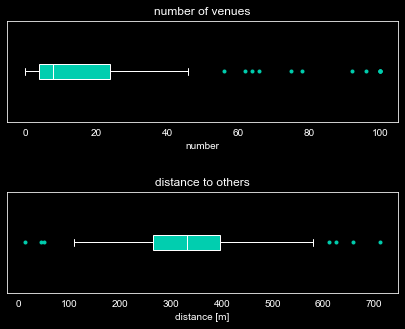

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})
plt.style.use("dark_background")

fig, ax = plt.subplots(2, figsize=(7,5))
plt.subplots_adjust(hspace = 0.7)

ax[0].boxplot(table_cat['Number of venues'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='#01CEAF', color='w'),
            capprops=dict(color='w'),
            whiskerprops=dict(color='w'),
            flierprops=dict(marker='.', markerfacecolor='#01CEAF', color='#01CEAF', markeredgecolor='#01CEAF'),
            medianprops=dict(color='w'),
            ) #color='#01CEAF')

ax[0].set_title('number of venues')
ax[0].set_xlabel('number')

ax[1].boxplot(table_cat['Distance to others'][~np.isnan(table_cat['Distance to others'])], vert=False, patch_artist=True,
            boxprops=dict(facecolor='#01CEAF', color='w'),
            capprops=dict(color='w'),
            whiskerprops=dict(color='w'),
            flierprops=dict(marker='.', markerfacecolor='#01CEAF', color='#01CEAF', markeredgecolor='#01CEAF'),
            medianprops=dict(color='w'),
            ) #color='#01CEAF')

ax[1].set_title('distance to others')
ax[1].set_xlabel('distance [m]')

for ax in fig.get_axes():
    ax.set_yticks([])
    
fig.savefig('figures/boxplots_bnw.png', transparent=True, dpi=300)

The vast majority of Neighborhoods has below 43 venues (maximum: median(8 venues) + 1.5 * 3rd quartile(23)), with the interquartile range (IQR) spanning 4 to 23 venues. With only a few outliers we can assume that most neighborhoods are captured representatively.

All data points apart from 7 are also captured in the IQR for the mean distance of venues to other venues. Let us have a closer look at this feature.

We can directly use a regression plot to see if a simple linear model can find a correlation.

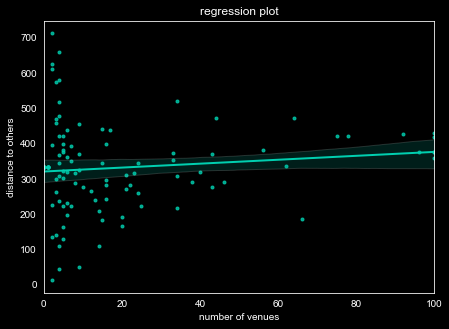

In [38]:
fig, ax = plt.subplots(figsize=[7,5])

sns.regplot(table_cat['Number of venues'], table_cat['Distance to others'], marker='.',
            color="#01CEAF", ax=ax, line_kws={'lw': 2}).set_title('regression plot', color='w')
plt.ylabel("distance to others").set_color('w')
plt.xlabel("number of venues").set_color('w')
    
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

fig.savefig('figures/distance_regplot_darkmode.png', transparent=True, dpi=300)

A joint distribution plot is also a nice way of visualizing such relationships.

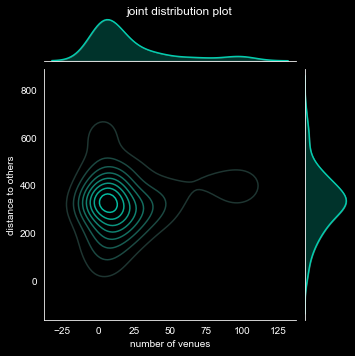

In [39]:

#fig, ax = plt.subplots(figsize=[7,5])


cmap = sns.dark_palette(color="#01CEAF", as_cmap=True)

sns_plot = sns.jointplot(table_cat['Number of venues'], table_cat['Distance to others'],
              cmap=cmap, kind='kde', color="#01CEAF", shade=False, height=5)
sns_plot.set_axis_labels("number of venues", "distance to others")
plt.subplots_adjust(top=0.95)
sns_plot.fig.suptitle('joint distribution plot')
#ax.grid(False)
#ax.set_title('Regression plot', color='w')
#ax.set_ylabel("Distance to others").set_color('w')
#plt.xlabel("Number of venues").set_color('w')
    
#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
#ax.spines['right'].set_color('white')
#ax.spines['left'].set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')

sns_plot.savefig('figures/distance_jointplot_darkmode.png', transparent=True, dpi=300)


Let us also create figures with the 2-dimensional distribution of each of the two features over the different neighborhoods.

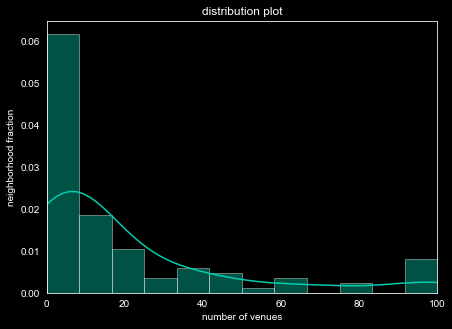

In [40]:
fig, ax = plt.subplots(figsize=[7,5])
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.style.use("dark_background")
sns_plot = sns.distplot(table_cat['Number of venues'], color="#01CEAF", ax=ax)
sns_plot.set(xlim=(0, 100))
#ax.grid(False)
ax.set_title('distribution plot', color='w')
ax.set_ylabel("neighborhood fraction").set_color('w')
ax.set_xlabel("number of venues").set_color('w')
#plt.xlabel("Number of venues").set_color('w')
    
#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
#ax.spines['right'].set_color('white')
#ax.spines['left'].set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')

plt.savefig('figures/distance_disttplot_darkmode.png', transparent=True, dpi=300)


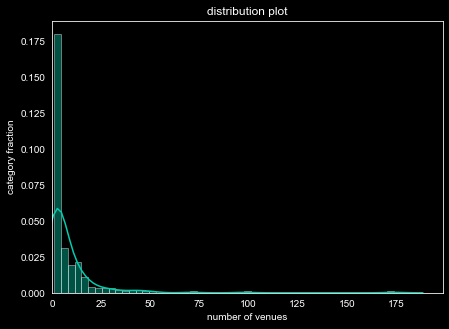

In [41]:
fig, ax = plt.subplots(figsize=[7,5])
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.style.use("dark_background")
sns_plot = sns.distplot(np.sum(table_cat.iloc[:,7:]), color="#01CEAF", ax=ax)
sns_plot.set(xlim=(0))
#ax.grid(False)
ax.set_title('distribution plot', color='w')
ax.set_ylabel("category fraction").set_color('w')
ax.set_xlabel("number of venues").set_color('w')
    
#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
#ax.spines['right'].set_color('white')
#ax.spines['left'].set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')

plt.savefig('figures/distance_disttplot_categories_darkmode.png', transparent=True, dpi=300)


A polynomial model can likely better fit the correlation of the venue distances and venue counts.

In [42]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(0, 100, 100)
    y_new = model(x_new)
    fig = plt.figure(figsize=(7,5))
    plt.plot(independent_variable, dependent_variabble, marker='.', color='#01CEAF', linestyle="None")
    plt.plot(x_new, y_new, marker='None', color='#01CEAF')
    plt.title('polynomial fit (degree=3)').set_color('w')
    ax = plt.gca()
    #ax.patch.set_facecolor((0.898, 0.898, 0.898))
    plt.gcf()
    #fig.patch.set_facecolor((0.898, 0.898, 0.898))
    plt.ylabel("distance to others").set_color('w')
    plt.xlabel("number of venues").set_color('w')
#    plt.yticks(np.linspace(-10000,50000,7))
#    plt.xticks(np.linspace(15,55,9))
    
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.ylim(0,50000)
    plt.xlim(0,100)
    fig.savefig('figures/distance_polynomial_darkmode.png', transparent=True, dpi=300)
    plt.show()
    plt.close()

In [43]:
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [44]:
x = table_cat['Number of venues']
y = table_cat['Distance to others']

In [45]:
# Here we use a polynomial of the 3rd order (cubic) 
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

           3          2
-0.001177 x + 0.1878 x - 6.756 x + 360


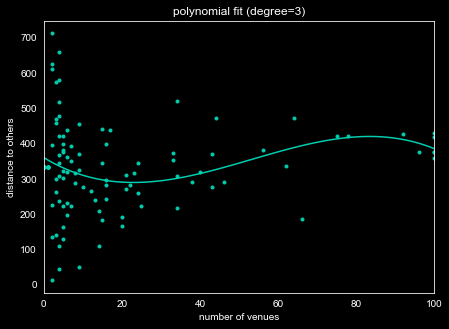

{'polynomial': [-0.0011772783850536362,
  0.18781369487133304,
  -6.756282556293879,
  359.95188671945624],
 'determination': 0.06000070570255653}

In [46]:
PlotPolly(p, x, y, 'distance to others')
polyfit(x, y, 3)


Interestingly, an increasing amount of registered venues is not clearly correlated with decreasing distance between the venues. Neighborhoods with low amounts of recorded venues sometimes have them very close to each other, sometimes far from each other. With increasing amount of recorded venues, mainly the distribution becomes more narrow rather than showing a decreasing mean distance.

They rather seem to be closely clustered, which also makes sense. This indicates that Toronto is heavy in "High Street" and "Shopping Mall" arrangements where even with lower venue amounts they gather quite closely.

<h3>3.6 Clustering Toronto Neighborhoods</h3>

Let us now cluster our neighborhoods with a few different algorithms and see how it turns out.

First let us see how K-Means with k-means++ initialization does.

We will append the results to table_cat_clusters. We will also make a list called method to store all methods that we try for later visualization.

In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

X = StandardScaler().fit_transform(table_cat.iloc[:,5:])
methods=[]
method='K-Means (k-means++)'

kmeans = KMeans(n_clusters=5, random_state=0, algorithm='auto', init='k-means++').fit(X)
#kmeans.labels_==2
#kmeans.cluster_centers_

for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 2 neighborhoods belong to cluster 0: 33, 96
The following 9 neighborhoods belong to cluster 1: 9, 15, 20, 30, 36, 42, 48, 92, 97
The following 1 neighborhoods belong to cluster 2: 99
The following 1 neighborhoods belong to cluster 3: 84
The following 90 neighborhoods belong to cluster 4: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 98, 100, 101, 102


Let us see how random initialization does.

In [51]:
method='K-Means (Random)'

kmeans = KMeans(n_clusters=5, random_state=0, algorithm='auto', init='random').fit(X)

for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 1 neighborhoods belong to cluster 0: 99
The following 89 neighborhoods belong to cluster 1: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 34, 35, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102
The following 10 neighborhoods belong to cluster 2: 9, 15, 20, 30, 36, 42, 48, 84, 92, 97
The following 2 neighborhoods belong to cluster 3: 24, 37
The following 1 neighborhoods belong to cluster 4: 33


Our data consists of only 103 samples with 273 features. Principal component analysis might be valuable for increasing the meaningfulness of our features.

In [52]:
from sklearn import decomposition

method='K-Means (PCA)'
pca = decomposition.PCA(n_components=50)
pca.fit(X)
X = pca.transform(X)

kmeans = KMeans(n_clusters=5, random_state=0, algorithm='auto').fit(X)
#kmeans.labels_==2
#kmeans.cluster_centers_

for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 1 neighborhoods belong to cluster 0: 99
The following 96 neighborhoods belong to cluster 1: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102
The following 4 neighborhoods belong to cluster 2: 30, 42, 48, 97
The following 1 neighborhoods belong to cluster 3: 36
The following 1 neighborhoods belong to cluster 4: 84


Now we will also perform agglomerative clustering.

In [53]:
from sklearn.cluster import AgglomerativeClustering

method='Agglomerative Clustering'
X = StandardScaler().fit_transform(table_cat.iloc[:,5:])
AC = AgglomerativeClustering(n_clusters=5).fit(X)

for label in set(AC.labels_):
    label_list =[]
    for index, g in enumerate(AC.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(AC.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 3 neighborhoods belong to cluster 0: 9, 33, 84
The following 91 neighborhoods belong to cluster 1: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102
The following 7 neighborhoods belong to cluster 2: 15, 20, 30, 42, 48, 92, 97
The following 1 neighborhoods belong to cluster 3: 99
The following 1 neighborhoods belong to cluster 4: 36


A dendrogram can better show how the agglomerative clustering performed. But we will visualize the results on a map and check the algorithm of choice with an elbow plot as well.

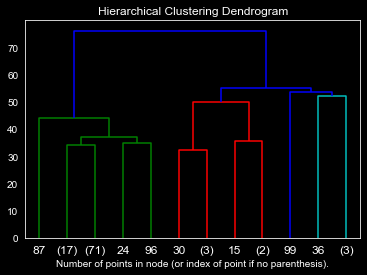

In [54]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Neighborhood 99 seems quite interesting. All algorithms return it in a single sample cluster.

In [55]:
table_cat.iloc[99,:]

Postal Code                              M4Y
Borough                     Downtown Toronto
Neighborhood            Church and Wellesley
Latitude                             43.6659
Longitude                           -79.3832
                                ...         
Ethiopian Restaurant                       0
Other Great Outdoors                       0
Indie Movie Theater                        0
Poke Place                                 0
Art Gallery                                0
Name: 99, Length: 278, dtype: object

In [56]:
from sklearn.cluster import DBSCAN

method='DBSCAN'
X = StandardScaler().fit_transform(table_cat.iloc[:,5:])
dbscan = DBSCAN(eps=5, min_samples=5).fit(X)

for label in set(dbscan.labels_):
    label_list =[]
    for index, g in enumerate(dbscan.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(AC.labels_).rename(columns={0:method})], axis=1)
methods.append(method)



The following 17 neighborhoods belong to cluster 0: 5, 6, 10, 11, 12, 32, 35, 39, 50, 52, 56, 64, 66, 72, 83, 85, 95
The following 86 neighborhoods belong to cluster -1: 0, 1, 2, 3, 4, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102


This makes sense that the central downtown seems quite outstanding among the compared neighborhood. Lets head on!

<h3>3.7 Function for Automatic Clustering</h3>

Let us go ahead and define running these clustering models as function for later interactive use.

In [57]:
def clustering(Venue_Numbers, Total_Number, Mean_Distance, n_clusters, Report):
    """
    This function runs all clustering algorithms that we chose to cluster our neighborhoods.
    
    Variables:
        Venue_Numbers (String): 'Absolute' or 'Relative'. Defines if we divide venue numbers
            by total venue number before using the dataframe.
        Total_Number (Boolean): Defines if total venue number shall be used.
        Mean_Distance (Boolean): Defines if the mean distance shall be used.
        n_clusters (Integer): Defines the number of clusters to generate.
        Report (Boolean): Defines if a report shall be printed summarizing the total no. of 
            neighborhoods in a cluster and listing all contained clusters for each clustering
            algorithm.
    
    It returns:
    table_cat_clusters
    
    This is our old table_cat concatenated with the cluster labels of the different clustering
    algorithms.
    """

    #Let us introduce filter methods in order to be able to use/ignore the mean distance of locations,
    #the total number of avenues and also to be able to either use relative or absolute venue
    #numbers.
    if Venue_Numbers=='Absolute':
        table_clusters = table_cat.iloc[:,5:]
        if Total_Number==False:
            table_clusters.drop(columns='Number of venues')
        if Mean_Distance==False:
            table_clusters.drop(columns='Distance to others')
            
    else:
        table_clusters = pd.concat([table_cat.iloc[:,5:7], table_cat.iloc[:,7:].divide(table_cat.iloc[:,6], axis=0)], axis=1)
        table_clusters.fillna(value=0, inplace=True)
        if Total_Number==False:
            table_clusters.drop(columns='Number of venues')
        if Mean_Distance==False:
            table_clusters.drop(columns='Distance to others')
    
    #Now let us scale, fit and transform the resulting table for use in our ML algorithms.
    X = StandardScaler().fit_transform(table_clusters)
    
    #
#    methods=[]

    #K-Means with k-means++ initialization
    method='K-Means (k-means++)'
    kmeans = KMeans(n_clusters, random_state=0, algorithm='auto', init='k-means++').fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(kmeans.labels_):
        label_list =[]
        for index, g in enumerate(kmeans.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
#    methods.append(method)

    #K-Means with random initialization
    method='K-Means (Random)'
    kmeans = KMeans(n_clusters, random_state=0, algorithm='auto', init='random').fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(kmeans.labels_):
        label_list =[]
        for index, g in enumerate(kmeans.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
#    methods.append(method)

    #K-Means with auto initialization and principal component analysis
    method='K-Means (PCA)'
    pca = decomposition.PCA(n_components=50)
    pca.fit(X)
    X = pca.transform(X)

    kmeans = KMeans(n_clusters, random_state=0, algorithm='auto').fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(kmeans.labels_):
        label_list =[]
        for index, g in enumerate(kmeans.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
#    methods.append(method)

    #Agglomerative Clustering
    method='Agglomerative Clustering'
    X = StandardScaler().fit_transform(X)
    AC = AgglomerativeClustering(n_clusters).fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(AC.labels_):
        label_list =[]
        for index, g in enumerate(AC.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(AC.labels_).rename(columns={0:method})], axis=1)
#    methods.append(method)
    
    #DBSCAN
    method='DBSCAN'
    X = StandardScaler().fit_transform(X)
    dbs = DBSCAN().fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(dbs.labels_):
        label_list =[]
        for index, g in enumerate(dbs.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(dbs.labels_).rename(columns={0:method})], axis=1)
#    methods.append(method)
    
    return table_cat_clusters


Check if the help function works.

In [58]:
help(clustering)

Help on function clustering in module __main__:

clustering(Venue_Numbers, Total_Number, Mean_Distance, n_clusters, Report)
    This function runs all clustering algorithms that we chose to cluster our neighborhoods.
    
    Variables:
        Venue_Numbers (String): 'Absolute' or 'Relative'. Defines if we divide venue numbers
            by total venue number before using the dataframe.
        Total_Number (Boolean): Defines if total venue number shall be used.
        Mean_Distance (Boolean): Defines if the mean distance shall be used.
        n_clusters (Integer): Defines the number of clusters to generate.
        Report (Boolean): Defines if a report shall be printed summarizing the total no. of 
            neighborhoods in a cluster and listing all contained clusters for each clustering
            algorithm.
    
    It returns:
    table_cat_clusters
    
    This is our old table_cat concatenated with the cluster labels of the different clustering
    algorithms.



Good, that should help others to use this function as well.

<h3>3.8 Neighborhood Clustering Visualizaton</h3>

We will now plot a map of Toronto and label our neighborhoods. First, get the coordinates of Toronto for centering the maps.

In [59]:
g = geocoder.osm('Toronto, Ontario'.format(postal_code))
lat_lng_coords = g.latlng


latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


Let us write a function that uses a webdriver for Google Chrome to open our folium map and save reproducible screenshots for our use in the report and presentation.

In [60]:
def map_screenshot(mapname, mapfilename):
        file = '{}.html'.format(mapfilename)
        file_directory = '/C:/Users/Admin/Documents/Resources/Data%20Science%20Professional%20Certificate/data_science_pro_certification/'
        file_name = 'file://' + file_directory + file

        mapname.save(file)
        driver = webdriver.Chrome()  # Optional argument, if not specified will search path.
        driver.get(file_name)
        driver.set_window_size(1500,1500)  # choose a resolution
        # You may need to add time.sleep(seconds) here to allow opening the map before
        # taking the screenshot.
        time.sleep(15)
        driver.save_screenshot('figures/{}.png'.format(mapfilename))

Now let us plot the neighborhood centers.

In [61]:
import folium.plugins
from folium.features import *
import io
from PIL import Image
from selenium import webdriver

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.TileLayer('cartodbdark_matter').add_to(map_toronto)

# add markers to map
for lat, lng, borough, neighborhood in zip(table_cat['Latitude'], table_cat['Longitude'], table_cat['Borough'], table_cat['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#01CEAF',
        fill=True,
        fill_color='#01CEAF',
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)
    
map_screenshot(map_toronto, mapfilename="map_postal_codes")

map_toronto

The following code defines the style for html markers that we can add to automatize text labels in folium maps.

In [62]:

    
class DivIcon(MacroElement):
    def __init__(self, html='', size=(30,30), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style

        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

Now we will plot a more useful map! Let us make an interactive map where we can look at the different clustering algorithms (together with the number of clusters) and also chose if we want the total number and mean distance of venues included. Furthermore, we want to be able to chose using either relative or absolute venue numbers. This is an important difference depending on what we want to achieve with our analysis in later parts of this project. Relative numbers give an insight into the structure of existing venues, but absolute numbers are also important for making a call on where starting a new business might be important. A neighborhood lacking a Chinese restaurant but being filled with dozens of others is not a smart place to open one. Additional funcationality for getting a zoom into the most interesting region and for generating a written report were added.

In [117]:
from matplotlib import cm, colors
from ipywidgets import interact
import ipywidgets as widgets

def Draw_Map(Venue_Numbers, Total_Number, Mean_Distance, Method, n_clusters, Show_Venues, Zoom_City_Centre, Black_and_White, Screenshot, Report):
    
    n_clusters=int(n_clusters)
    table_cat_clusters = clustering(Venue_Numbers, Total_Number, Mean_Distance, n_clusters, Report)
     
    # different zoom levels with different marker sizes.
    if Zoom_City_Centre==True:
        initial_zoom_int = 14
        marker_radius = 9
    else:
        initial_zoom_int = 10
        marker_radius = 3
        
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=initial_zoom_int)
    
    # add dark layer if the black and white option gets enabled.
    if Black_and_White==True:
        folium.TileLayer('cartodbdark_matter').add_to(map_clusters)

    #kclusters=table_cat_clusters[method].max()+1
    # set color scheme for the clusters
    x = np.arange(n_clusters)
    ys = [i + x + (i*x)**2 for i in range(n_clusters)]
    colors_array = cm.rainbow((np.linspace(0, 1, len(ys))+0.1)/1.1)
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, venue_count in zip(table_cat_clusters['Latitude'], table_cat_clusters['Longitude'], table_cat_clusters['Neighborhood'], table_cat_clusters[Method], table_cat_clusters['Number of venues']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        
        #Let us define the index for our marker color by the appearance rate for easier visual comparison
        for i in range(int(len(table_cat_clusters[Method].unique()))):
            if cluster==table_cat_clusters[Method].value_counts().index[i]:
                marker_color = i
            else:
                None
        
        #Create circle markers with different colors for each cluster.
        folium.CircleMarker(
            [lat, lon],
            radius=marker_radius,
            popup=label,
            color=rainbow[marker_color],
            fill=True,
            fill_color=rainbow[marker_color],
            fill_opacity=0.7).add_to(map_clusters)
        
        #Add text markers denouncing the total number of venues in the neighborhood.
        if Show_Venues==True:
            folium.map.Marker(
                [lat, lon],
                icon=DivIcon(
                size=(150,36),
                anchor=(170,8),
                html=str(venue_count),
                style="""
                    font-size:12px;
                    background-color: transparent;
                    border-color: transparent;
                    text-align: right;
                    """
            )
            ).add_to(map_clusters)

    if Screenshot == True:

        # Edit the filename according to the chosen options to easily export screenshots of
        # everything we find interesting.
        text_zoom=""
        if Zoom_City_Centre== True:
            text_zoom="_zoom"
            
        text_bnw=""
        if Black_and_White==True:
            text_bnw="_bnw"
        
        text_labels=""
        if Show_Venues==True:
            text_labels="_labels"
            
        text_absrel=""
        if Venue_Numbers=='Absolute':
            text_absrel="_abs"
        
        map_screenshot(map_clusters, mapfilename="map{}{}{}{}{}{}".format("_"+Method,
                                                                          n_clusters,
                                                                          text_zoom,
                                                                          text_bnw,
                                                                          text_labels,
                                                                          text_absrel))
    
    return map_clusters


import ipywidgets as widgets

interact(Draw_Map, Venue_Numbers=['Relative', 'Absolute'],
    Total_Number=True,
    Mean_Distance=True,
    Method=methods,
    n_clusters=widgets.IntSlider(min=1, max=10, step=1, value=5, continuous_update=False),
    Show_Venues=False, 
    Zoom_City_Centre=False,
    Black_and_White=False,
    Screenshot=False,
    Report=False
    )



interactive(children=(Dropdown(description='Venue_Numbers', options=('Relative', 'Absolute'), value='Relative'…

<function __main__.Draw_Map(Venue_Numbers, Total_Number, Mean_Distance, Method, n_clusters, Show_Venues, Zoom_City_Centre, Black_and_White, Screenshot, Report)>

Let us now plot the error/distortion of our clustering algorithm to look for an elbow which indicates a good number of clusters k.

Very cool!

We now have an interactive map and can look at different clustering algorithms and at different data treatment ways all in one! It seems that mainly the dense areas get grouped in different clusters than areas with less recorded venues. We will likely want to focus on the 1 or 2 clusters containing the most neighborhoods which are rather sparsely equipped with venues currently to minimize competition.

As interactive widgets will not show on Github or on NBViewer, please find a screenshot of above map here. Feel free to download the notebook and test it yourself!

<img src="figures/interactive_map.PNG"/>

One thing that this analysis makes very clear is that we will definitely need to use relative venue counts in order to include some of the neighborhoods outside of the very center into our analysis.

It is easier to follow the results with the stamentoner layer (black and white) or with cartodbdark_matter which we later chose for our presentation.

<img src="figures/map_K-Means (k-means++)5_bnw_abs.PNG"/>

Switching to relative will lead to very different clusters:

<img src="figures/map_K-Means (k-means++)5_bnw.PNG"/>

Using random initialization instead of k-means++ only shows slight differences:

<img src="figures/map_K-Means (Random)5_bnw.PNG"/>

Principal Component Analysis seems very valuable for further regression analysis, as we can reduce the dimensionality of our matrix. We only have 103 samples with over 250 features. This does, however, lead to only different clusters being captured in the city center. All outskirts are just seen as one cluster.

<img src="figures/map_K-Means (PCA)5_bnw.PNG"/>

Agglomerative clustering was also looked into. Similar to PCA, it fails to find structures in the non-downtown clusters.

<img src="figures/map_Agglomerative Clustering5_bnw.png"/>



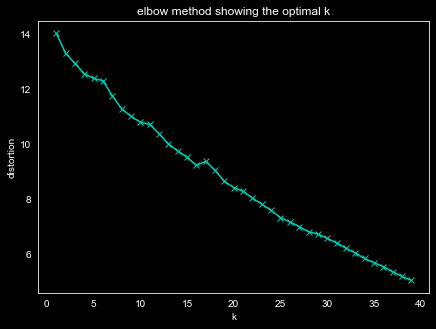

In [64]:
from scipy.spatial.distance import cdist
X = StandardScaler().fit_transform(table_cat.iloc[:,5:])
# create new plot and data

# k means determine k
distortions = []
K = range(1,40)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0, algorithm='auto', init='k-means++').fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
fig = plt.figure(figsize=[7,5])
plt.plot(K, distortions, 'bx-', color="#01CEAF")
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('elbow method showing the optimal k')
fig.savefig('figures/elbow.png', transparent=True, dpi=300)


<h3>3.9 Building a Predictive Model</h3>

We now used the complete dataframe to build predictive models for each of the contained numeric values. This can be used to identify which venue categories are underrepresented so that we can isolate good places to install new venues.

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#Other models that I experimented with here as well. However, linear regression seems inappropriate as it extremely
#overfit data, delivering R2 values of 1.0 frequently. Polynomial features are discussed below. The KernelRidge delivered
#very poor R2 scores.

#from sklearn.linear_model import LinearRegression as LR
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.kernel_ridge import KernelRidge
#from sklearn.pipeline import make_pipeline

columns = table_cat.columns.to_list()
columns = [e for e in columns if e not in ('Postal Code', 'Neighborhood', 'Borough', 'Latitude', 'Longitude')]

table_yhat = pd.DataFrame(columns=columns)
r2_scores = []

start = time.time()

for column in columns:
    #We will use each column as y for one ridge regression model.
    y = table_cat.loc[:,column]
    #This retrieves all numeric columns from table_cat
    X = table_cat.loc[:,columns]
    #Now we drop the column that is used as dependent variable for our model.
    X.drop(columns=column, inplace=True)

    #Including below code can be used for polynomial regression. However, our matrix is already ill-defined with
    #260 features for only 103 neighborhoods used for training.
    #poly=PolynomialFeatures(3)
    #poly.fit_transform(X)

    #Using principal component analysis is much more interesting as we can reduce the number of features,
    #creating a better defined matrix for regression.

    #pca = decomposition.PCA(n_components=50)
    #pca.fit(X)
    #X = pca.transform(X)
    
    model = Ridge()
    
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('model', model)])
    
    
    parameters = {'model__alpha':[1e-15, 1e-10, 1e-5, 1, 3, 10, 30, 90], 'pca__n_components': [5, 15, 30, 45, 64]}
    
    ridge_regressor = GridSearchCV (pipe, parameters, scoring='neg_mean_squared_error', cv=5)
    ridge_regressor.fit(X,y)
         
    #Now store the predicted values in table_yhat so that we basically have a mirror of table_cat with predicted values for
    #all relevant columns.
    table_yhat[column]=ridge_regressor.predict(X)
    
    #Let us also store the R2 values for each of the predicted rows so that we can make sure not to use a very inaccurate
    #one to base our conclusions on later.
    r2_scores.append(r2_score(y, table_yhat[column]))


end = time.time()
print("... done!\nTime elapsed: " + str(round((end - start),2)) + " s")

... done!
Time elapsed: 754.71 s


We used ridge regression for this to reduce bias and trained models with 5-fold cross-validation to minimize bias further. Each model was trained using all variables as independent variables apart from the column that we wanted to predict.

We now have a dataframe containing predicted values for each of our numeric columns. Let us have a look at the R2 scores that our predictions delivered.

In [66]:
r2_scores[0:5]

[0.1366398440873967,
 0.9993512175387835,
 0.5586088993206754,
 0.9732125248531474,
 0.003616776550932066]

The first R2 value describes the model regarding the mean distance between venues. We have seen before that this does not correlate with the number of venues in a neighborhood. It is very plausible that this model delivers a poor R2 square of 0.14, while the next one is nearly 1. This second R2 describes the model regarding the total number of venues. Our model succesfully retrieves the total number of venues from the other columns.

The remaining columns are the numbers of venues from single categories which have individual R2 scores ranging from very good to very poor. We will come back to this list later to judge the accuracy of our conclusions.

Let us now form a dataframe containing the differences between the predicted data and our real data.

In [67]:
table_differences = table_cat.iloc[:,5:].subtract(table_yhat)
table_differences

Distance to others  Number of venues   Airport  \
0           -211.100166          1.352885 -0.014806   
1           -172.762376          0.413041  0.014938   
2             20.311447         -0.124731  0.008928   
3             15.221719          0.289954 -0.011713   
4            105.926140          0.367278 -0.000982   
..                  ...               ...       ...   
98           279.814500          0.388586 -0.042302   
99             6.605175          0.139084 -0.006112   
100          -27.782911          0.488900 -0.014036   
101            1.095326          0.404800 -0.011424   
102          -89.552024         -0.276430 -0.017489   

     Vegetarian / Vegan Restaurant  Auto Workshop  Strip Club  Lingerie Store  \
0                        -0.006172      -0.013140    0.002832       -0.018512   
1                        -0.079274      -0.011267    0.012144        0.013468   
2                        -0.013435      -0.003561   -0.010425       -0.000816   
3                         0.009824      -0.012775    0.001748       -0.024643   
4                         0.068359       0.002298   -0.041091       -0.008753   
..                             ...            ...         ...             ...   
98                        0.030137      -0.005465   -0.004065       -0.017587   
99                        0.022821      -0.010813    0.477490        0.000882   
100                       0.040847       0.987269   -0.016556       -0.009129   
101                       0.056151      -0.009735    0.007141       -0.003512   
102                       0.089047      -0.013656   -0.011694        0.001994   

       Bakery  Smoke Shop  Bus Line  ...  Salad Place  Sake Bar  \
0   -0.127354    0.024893 -0.038752  ...     0.101591  0.002832   
1   -0.058073    0.019997 -0.038152  ...    -0.055589  0.012144   
2    1.448398   -0.066130 -0.025402  ...    -0.061735 -0.010425   
3   -0.214773   -0.114227 -0.046453  ...     0.004733  0.001748   
4   -0.326787   -0.086022 -0.034287  ...    -0.402358 -0.041091   
..        ...         ...       ...  ...          ...       ...   
98  -0.050550   -0.005359 -0.077109  ...    -0.060064 -0.004065   
99  -0.704873    0.415000  0.000143  ...    -0.224792  0.477490   
100 -0.368652   -0.052279 -0.040676  ...     0.159083 -0.016556   
101 -0.041446    0.024208 -0.055964  ...    -0.016568  0.007141   
102  0.783991   -0.010843 -0.035626  ...     0.008709 -0.011694   

     General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
0                -0.007038     -0.132222     -0.003216              0.008526   
1                 0.013798      0.871307      0.001485              0.004583   
2                -0.055308     -0.047767      0.479632              0.001674   
3                 0.035807     -0.091218      0.003711             -0.063336   
4                -0.004271     -0.056018     -0.467494             -0.009456   
..                     ...           ...           ...                   ...   
98               -0.014797     -0.062324      0.051334              0.003204   
99                0.451134     -0.024130     -0.678538             -0.040651   
100              -0.048030     -0.095160     -0.145042             -0.009951   
101              -0.001990     -0.105585      0.066032              0.010195   
102              -0.024945     -0.111051     -0.087390              0.002764   

     Other Great Outdoors  Indie Movie Theater  Poke Place  Art Gallery  
0                0.008526            -0.003275   -0.008838     0.003743  
1                0.004583            -0.018057    0.000920    -0.010653  
2                0.001674            -0.116099   -0.014615     0.184367  
3               -0.063336             0.020151    0.020427    -0.034833  
4               -0.009456            -0.162176   -0.006752    -0.114543  
..                    ...                  ...         ...          ...  
98               0.003204             0.024304    0.007006     0.006226  
99           

Let us isolate the categories showing the largest difference between the predicted value (expected amount of venue category based on its other properties) and real value.

In [68]:
columns = table_differences.columns[2:]
venue_lack = {}

for column in columns:
    venue_lack[column] = table_differences[column].min()
    
venue_lack = pd.DataFrame.from_dict(venue_lack, orient='index', columns=['minimum_value']).sort_values(by='minimum_value')
venue_lack

minimum_value
Coffee Shop             -2.902505
Café                    -2.845782
Italian Restaurant      -1.927923
Restaurant              -1.432651
Sushi Restaurant        -1.423847
...                           ...
Hakka Restaurant        -0.019802
Basketball Court        -0.019657
Farm                    -0.015048
College Stadium         -0.015048
Curling Ice             -0.014110

[271 rows x 1 columns]

Coffee shops and cafés are both in dire need. This also stresses that we need to take care with the category definitions, as these two seem almost identical. Let us visualize the venue demands.

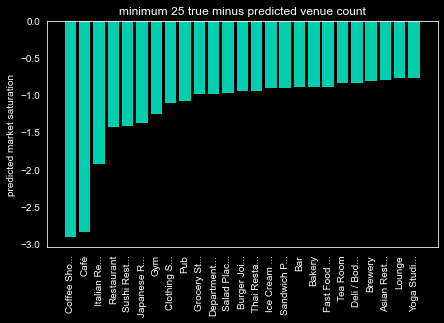

In [69]:
venue_lack_indices = venue_lack.index[0:25]
venue_lack_indices_shortened=[]
for category in venue_lack_indices:
    if len(category)>10:
        venue_lack_indices_shortened.append(category[:10-len(category)]+'...')
    else:
        venue_lack_indices_shortened.append(category)

fig = plt.figure(figsize=(7,5))


plt.bar(venue_lack_indices_shortened, venue_lack.iloc[:,0][0:25],
       color='#01CEAF', edgecolor="None")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.25)
plt.title(label='minimum 25 true minus predicted venue count')
plt.ylabel('predicted market saturation')
#plt.xlabel('venue category')
fig.savefig('figures/prediction_venmaxdemand.png', transparent=True, dpi=300)


We now have a list of venues that, based on the existence of other venues, describes which venues are missing the most in order to make a certain neighborhood fit in with other neighborhoods of similar structure. Let us look at the neighborhoods that seem to lack almost 3 coffee shops / 3 cafés to verify if opening a coffe shop there would be smart.

In [70]:
pd.concat([table_cat.loc[table_differences['Café']==table_differences['Café'].min()],
           table_cat.loc[table_differences['Coffee Shop']==table_differences['Coffee Shop'].min()]],
           axis=0
           )

Postal Code           Borough                    Neighborhood   Latitude  \
99         M4Y  Downtown Toronto            Church and Wellesley  43.665860   
80         M5S  Downtown Toronto  University of Toronto, Harbord  43.662696   

    Longitude  Distance to others  Number of venues  Airport  \
99 -79.383160               421.0                75        0   
80 -79.400049               309.0                34        0   

    Vegetarian / Vegan Restaurant  Auto Workshop  ...  Salad Place  Sake Bar  \
99                              0              0  ...            0         1   
80                              0              0  ...            0         0   

    General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
99                      1             0             0                     0   
80                      0             0             1                     0   

    Other Great Outdoors  Indie Movie Theater  Poke Place  Art Gallery  
99                     0                    0           0            0  
80                     0                    0           0            0  

[2 rows x 278 columns]

In [71]:
table_cat.loc[80,'Coffee Shop']

0

Indeed, the University of Toronto neighborhood completely lacks coffee shops. However, let us look at the existing venues.

In [72]:
table_cat.iloc[99,7:].sort_values(ascending=False)

Sushi Restaurant       5
Coffee Shop            5
Japanese Restaurant    4
Gay Bar                3
Restaurant             3
                      ..
Board Shop             0
Snack Place            0
Warehouse Store        0
Bistro                 0
Airport                0
Name: 99, Length: 271, dtype: object

In [73]:
print(
    'The neighborhood {} only has {} coffee shops but {} cafés.\nThe neighborhood {} has {} coffee shops but only {} café.'.format(
        table_cat.loc[80,'Neighborhood'],
        table_cat.loc[80,'Coffee Shop'],
        table_cat.loc[80,'Café'],
        table_cat.loc[99,'Neighborhood'],
        table_cat.loc[99,'Coffee Shop'],
        table_cat.loc[99,'Café']))

The neighborhood University of Toronto, Harbord only has 0 coffee shops but 5 cafés.
The neighborhood Church and Wellesley has 5 coffee shops but only 1 café.


This is likely a data collection problem. Depending on the location, different categories were chosen for otherwise comparable venues. Let us see if these venues are actually in demand or if the demand is saturated in the neighborhoods.

In [74]:
pd.DataFrame.from_dict({table_cat.loc[80,'Neighborhood']:
                        [table_differences.loc[80,'Coffee Shop'], table_differences.loc[80,'Café']],
                        table_cat.loc[99,'Neighborhood']:
                        [table_differences.loc[99,'Coffee Shop'], table_differences.loc[99,'Café']]},
                       orient='index',
                       columns=['Coffee Shops', 'Café']
                       )

Coffee Shops      Café
University of Toronto, Harbord     -2.902505  3.080050
Church and Wellesley               -1.623507 -2.845782

In the University of Toronto neighborhood the need for coffee seems well balanced, like all things should be. However, looking at both coffee shops and cafés in Curch and Wellesley actually uncover an even less saturated demand. This is great, I like coffee, and opening a café was always my second options in case other life plan would not make me happy in the long run. We will return to this later!

Let us first make sure that we do not miss further categories that cater the same needs as coffee shops and cafés. While our Principal Component Analysis did this job for us during clustering, we can now easily see that the detailed category definitions of Foursquare make our decision a bit harder at this point. While the University of Toronto neighborhood lacks coffee shops, 5 cafés are registered. We will need to group similar categories in order to identify actual venue lacks in neighborhoods.

<h3>3.10 Visualization of categories and neighborhoods by 2D-PCA</h3>

Let us now reduce the dimensionality of our categories even further, we might find some basic underlying principles of the data structure.

Let us perform a 2-dimensional PCA on our data set to be able to visualize it.

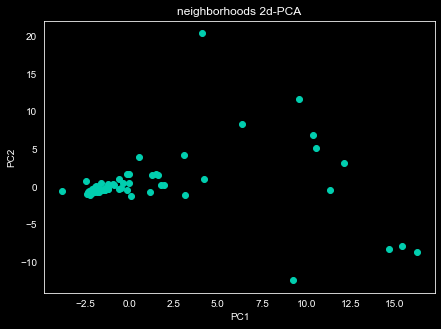

In [75]:
table_clusters = pd.concat([table_cat.iloc[:,5:7], table_cat.iloc[:,7:].divide(table_cat.iloc[:,6], axis=0)], axis=1)
table_clusters.fillna(value=0, inplace=True)
X = StandardScaler().fit_transform(table_clusters)
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)

fig = plt.figure(figsize=(7,5))
for i in range (0, pca_2d.shape[0]):
    plt.scatter(pca_2d[i,0], pca_2d[i,1], label=str(i), c='#01CEAF')
    plt.title('neighborhoods 2d-PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.annotate(i, (pca_2d[i,0], pca_2d[i,1]))
    
fig.savefig('figures/neighborhoods_2dpca.png', transparent=True, dpi=300)

Let us look at some points that we could identify as extremes on the PCA axes.

In [76]:
table_cat.iloc[[15, 87, 20, 99, 54, 74, 102],:]

Postal Code           Borough  \
15          M5C  Downtown Toronto   
87          M5V  Downtown Toronto   
20          M5E  Downtown Toronto   
99          M4Y  Downtown Toronto   
54          M4M      East Toronto   
74          M5R   Central Toronto   
102         M8Z         Etobicoke   

                                          Neighborhood   Latitude  Longitude  \
15                                      St. James Town  43.651494 -79.375418   
87   CN Tower, King and Spadina, Railway Lands, Har...  43.628947 -79.394420   
20                                         Berczy Park  43.644771 -79.373306   
99                                Church and Wellesley  43.665860 -79.383160   
54                                     Studio District  43.659526 -79.340923   
74                 The Annex, North Midtown, Yorkville  43.672710 -79.405678   
102  Mimico NW, The Queensway West, South of Bloor,...  43.628841 -79.520999   

     Distance to others  Number of venues  Airport  \
15                420.0                78        0   
87                282.0                16        1   
20                382.0                56        0   
99                421.0                75        0   
54                320.0                40        0   
74                271.0                21        0   
102               208.0                14        0   

     Vegetarian / Vegan Restaurant  Auto Workshop  ...  Salad Place  Sake Bar  \
15                               1              0  ...            0         0   
87                               0              0  ...            0         0   
20                               1              0  ...            0         0   
99                               0              0  ...            0         1   
54                               0              0  ...            0         0   
74                               1              0  ...            0         0   
102                              0              0  ...            0         0   

     General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
15                       0             0             0                     0   
87                       0             0             0                     0   
20                       0             0             0                     0   
99                       1             0             0                     0   
54                       0             0             0                     0   
74                       0             0             0                     0   
102                      0             0             0                     0   

     Other Great Outdoors  Indie Movie Theater  Poke Place  Art Gallery  
15                      0                    0           1            1  
87                      0                    0           0            0  
20                      0                    0           0            1  
99                      0                    0           0            0  
54                      0                    0           0            0  
74                      0                    0           0            0  
102                     0                    0           0            0  

[7 rows x 278 columns]

Looking at some of the data points shows that the large cluster of data points represents low density neighborhoods. The x-axis seems to correspond to higher venue counts with increasing values. The y-axis captures a certain feature distinguishing different venue categories. The total count rises both with positive and negative y-values but with different category structures of the data. This mainly reaffirms that such structure are in the dataset so that clustering of categories can yield good results.

Let us now transpose the dataframe to see if we can capture common structures within our categories rather than our neighborhoods.

In [77]:
#Transpose the category columns of our dataframe to prepare it for clustering
table_cat_t = table_cat.iloc[:,7:].transpose()
table_cat_t

0    1    2    3    4    5    6    7    8    \
Airport                          0    0    0    0    0    0    0    0    0   
Vegetarian / Vegan Restaurant    0    0    0    0    0    0    0    0    0   
Auto Workshop                    0    0    0    0    0    0    0    0    0   
Strip Club                       0    0    0    0    0    0    0    0    0   
Lingerie Store                   0    0    0    0    0    0    0    0    0   
...                            ...  ...  ...  ...  ...  ...  ...  ...  ...   
Ethiopian Restaurant             0    0    0    0    0    0    0    0    0   
Other Great Outdoors             0    0    0    0    0    0    0    0    0   
Indie Movie Theater              0    0    0    0    0    0    0    0    0   
Poke Place                       0    0    0    0    0    0    0    0    0   
Art Gallery                      0    0    1    0    0    0    0    0    0   

                               9    ...  93   94   95   96   97   98   99   \
Airport                          0  ...    0    0    0    0    0    0    0   
Vegetarian / Vegan Restaurant    0  ...    0    0    0    0    1    0    0   
Auto Workshop                    0  ...    0    0    0    0    0    0    0   
Strip Club                       0  ...    0    0    0    0    0    0    1   
Lingerie Store                   2  ...    0    0    0    0    0    0    0   
...                            ...  ...  ...  ...  ...  ...  ...  ...  ...   
Ethiopian Restaurant             1  ...    0    0    0    0    0    0    0   
Other Great Outdoors             1  ...    0    0    0    0    0    0    0   
Indie Movie Theater              0  ...    0    0    0    0    0    0    0   
Poke Place                       0  ...    0    0    0    0    0    0    0   
Art Gallery                      1  ...    0    0    0    0    1    0    0   

                               100  101  102  
Airport                          0    0    0  
Vegetarian / Vegan Restaurant    0    0    0  
Auto Workshop                    1    0    0  
Strip Club                       0    0    0  
Lingerie Store                   0    0    0  
...                            ...  ...  ...  
Ethiopian Restaurant             0    0    0  
Other Great Outdoors             0    0    0  
Indie Movie Theater              0    0    0  
Poke Place                       0    0    0  
Art Gallery                      0    0    0  

[271 rows x 103 columns]

 We will want to work with relative values again to fairly treat lower density areas. These might generate less income but will also produce less costs in rent etc.

In [78]:
table_cat_t = table_cat_t.divide(table_cat_t.sum(axis=1), axis=0)
table_cat_t.fillna(value=0.0, inplace=True)

table_cat_t

0    1         2    3    4    5    6    7    \
Airport                        0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Vegetarian / Vegan Restaurant  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Auto Workshop                  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Strip Club                     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Lingerie Store                 0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
...                            ...  ...       ...  ...  ...  ...  ...  ...   
Ethiopian Restaurant           0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Other Great Outdoors           0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Indie Movie Theater            0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Poke Place                     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Art Gallery                    0.0  0.0  0.076923  0.0  0.0  0.0  0.0  0.0   

                               8         9    ...  93   94   95   96   \
Airport                        0.0  0.000000  ...  0.0  0.0  0.0  0.0   
Vegetarian / Vegan Restaurant  0.0  0.000000  ...  0.0  0.0  0.0  0.0   
Auto Workshop                  0.0  0.000000  ...  0.0  0.0  0.0  0.0   
Strip Club                     0.0  0.000000  ...  0.0  0.0  0.0  0.0   
Lingerie Store                 0.0  0.400000  ...  0.0  0.0  0.0  0.0   
...                            ...       ...  ...  ...  ...  ...  ...   
Ethiopian Restaurant           0.0  1.000000  ...  0.0  0.0  0.0  0.0   
Other Great Outdoors           0.0  1.000000  ...  0.0  0.0  0.0  0.0   
Indie Movie Theater            0.0  0.000000  ...  0.0  0.0  0.0  0.0   
Poke Place                     0.0  0.000000  ...  0.0  0.0  0.0  0.0   
Art Gallery                    0.0  0.076923  ...  0.0  0.0  0.0  0.0   

                                    97   98   99   100  101  102  
Airport                        0.000000  0.0  0.0  0.0  0.0  0.0  
Vegetarian / Vegan Restaurant  0.055556  0.0  0.0  0.0  0.0  0.0  
Auto Workshop                  0.000000  0.0  0.0  1.0  0.0  0.0  
Strip Club                     0.000000  0.0  1.0  0.0  0.0  0.0  
Lingerie Store                 0.000000  0.0  0.0  0.0  0.0  0.0  
...                                 ...  ...  ...  ...  ...  ...  
Ethiopian Restaurant           0.000000  0.0  0.0  0.0  0.0  0.0  
Other Great Outdoors           0.000000  0.0  0.0  0.0  0.0  0.0  
Indie Movie Theater            0.000000  0.0  0.0  0.0  0.0  0.0  
Poke Place                     0.000000  0.0  0.0  0.0  0.0  0.0  
Art Gallery                    0.076923  0.0  0.0  0.0  0.0  0.0  

[271 rows x 103 columns]

Now let us perform the same 2d-PCA analysis regarding our transposed matrix to visualize categories rather than neighborhoods.

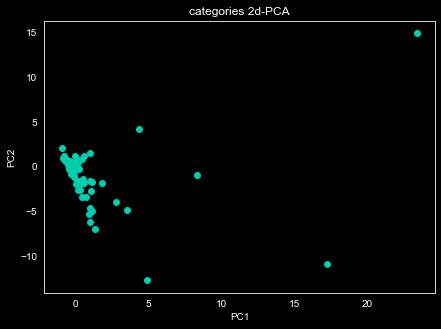

In [79]:
X = StandardScaler().fit_transform(table_cat_t)
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)

fig = plt.figure(figsize=(7,5))
for i in range (0, pca_2d.shape[0]):
    plt.scatter(pca_2d[i,0], pca_2d[i,1], label=str(i), c='#01CEAF')
    plt.title('categories 2d-PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.annotate(i, (pca_2d[i,0], pca_2d[i,1]))
    
fig.savefig('figures/categories_2dpca.png', transparent=True, dpi=300)

Very good. Let us have a look at some extremes in order to achieve a rough understanding of the meaning of the two principal components.

In [80]:
print(table_cat_t.iloc[193,:].name, ', ',
      table_cat_t.iloc[59,:].name, ', ',
      table_cat_t.iloc[4,:].name,
      )

Cajun / Creole Restaurant ,  Hookah Bar ,  Lingerie Store


In [118]:
table_cat[table_cat[table_cat_t.iloc[193,:].name]>0]

Postal Code       Borough                   Neighborhood   Latitude  \
69         M6P  West Toronto  High Park, The Junction South  43.661608   

    Longitude  Distance to others  Number of venues  Airport  \
69 -79.464763               222.0                25        0   

    Vegetarian / Vegan Restaurant  Auto Workshop  ...  Salad Place  Sake Bar  \
69                              0              0  ...            0         0   

    General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
69                      0             0             0                     0   

    Other Great Outdoors  Indie Movie Theater  Poke Place  Art Gallery  
69                     0                    0           0            0  

[1 rows x 278 columns]

In [82]:
table_cat[table_cat[table_cat_t.iloc[59,:].name]>0]

Postal Code           Borough  \
17          M9C         Etobicoke   
32          M1J       Scarborough   
33          M2J        North York   
35          M4J         East York   
36          M5J  Downtown Toronto   
43          M6K      West Toronto   
54          M4M      East Toronto   
56          M6M              York   
63          M6N              York   
66          M2P        North York   
67          M4P   Central Toronto   
82          M1T       Scarborough   
102         M8Z         Etobicoke   

                                          Neighborhood   Latitude  Longitude  \
17   Eringate, Bloordale Gardens, Old Burnhamthorpe...  43.643515 -79.577201   
32                                 Scarborough Village  43.744734 -79.239476   
33                        Fairview, Henry Farm, Oriole  43.778517 -79.346556   
35       East Toronto, Broadview North (Old East York)  43.685347 -79.338106   
36   Harbourfront East, Union Station, Toronto Islands  43.640816 -79.381752   
43        Brockton, Parkdale Village, Exhibition Place  43.636847 -79.428191   
54                                     Studio District  43.659526 -79.340923   
56    Del Ray, Mount Dennis, Keelsdale and Silverthorn  43.691116 -79.476013   
63                       Runnymede, The Junction North  43.673185 -79.487262   
66                                     York Mills West  43.752758 -79.400049   
67                                    Davisville North  43.712751 -79.390197   
82             Clarks Corners, Tam O'Shanter, Sullivan  43.781638 -79.304302   
102  Mimico NW, The Queensway West, South of Bloor,...  43.628841 -79.520999   

     Distance to others  Number of venues  Airport  \
17                 50.0                 9        0   
32                298.0                 3        0   
33                187.0                66        0   
35                458.0                 3        0   
36                417.0               100        0   
43                346.0                24        0   
54                320.0                40        0   
56                109.0                 4        0   
63                518.0                 4        0   
66                134.0                 2        0   
67                455.0                 9        0   
82                441.0                15        0   
102               208.0                14        0   

     Vegetarian / Vegan Restaurant  Auto Workshop  ...  Salad Place  Sake Bar  \
17                               0              0  ...            0         0   
32                               0              0  ...            0         0   
33                               0              0  ...            0         0   
35                               0              0  ...            0         0   
36                               1              0  ...            1         0   
43                               0              0  ...            0         0   
54                               0              0  ...            0         0   
56                               0              0  ...            0         0   
63                               0              0  ...            0         0   
66                               0              0  ...            0         0   
67                               0              0  ...            0         0   
82                               0              0  ...            0         0   
102                              0              0  ...            0         0   

     General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
17                       0             0             0                     0   
32                       0             0             0                     0   
33                       0             0             0                     0   
35                       0             0             0                     0   
36                       0             0             1                  

In [119]:
table_cat[table_cat[table_cat_t.iloc[4,:].name]>0]

Postal Code           Borough                  Neighborhood   Latitude  \
9          M5B  Downtown Toronto      Garden District, Ryerson  43.657162   
15         M5C  Downtown Toronto                St. James Town  43.651494   
33         M2J        North York  Fairview, Henry Farm, Oriole  43.778517   

    Longitude  Distance to others  Number of venues  Airport  \
9  -79.378937               360.0               100        0   
15 -79.375418               420.0                78        0   
33 -79.346556               187.0                66        0   

    Vegetarian / Vegan Restaurant  Auto Workshop  ...  Salad Place  Sake Bar  \
9                               0              0  ...            0         0   
15                              1              0  ...            0         0   
33                              0              0  ...            0         0   

    General Entertainment  Intersection  Dessert Shop  Ethiopian Restaurant  \
9                       0             0             1                     1   
15                      0             0             0                     0   
33                      0             0             0                     0   

    Other Great Outdoors  Indie Movie Theater  Poke Place  Art Gallery  
9                      1                    0           0            1  
15                     0                    0           1            1  
33                     0                    0           0            0  

[3 rows x 278 columns]

While the overview that we can achieve here is lacklustre, it seems that the x-axis correlates to the probability of high venue density. Venues with high x-values mainly appear in neighborhoods with many venues. The example here was the convenience store.

Higher y-values with low x-values represent venues that mainly appear in low venue density neighborhoods such as baseball fields.

Our most extreme example, the playground has high values of both and appears mainly in neighborhoods that contain a few venues resulting in intermediate venue density.

<h3>3.11 Category Clustering for Reduced Dimensionality</h3>

Let us use clustering algorithms to automatically identify similar venue categories.

K-Means can then be used to identify similar categories.

In [84]:
 
#Now let us scale, fit and transform the resulting table for use in our ML algorithms.
X = StandardScaler().fit_transform(table_cat_t)
    
#K-Means with auto initialization
method='K-Means (Random)'
kmeans = KMeans(n_clusters=30, random_state=0, algorithm='auto', init='k-means++').fit(X) #was 91 before
print('\nReport for {}:'.format(method))
for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)

    print('The following {} categories belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    
cat_labels = pd.DataFrame(kmeans.labels_, index=table_cat_t.index).rename(columns={0:method})
table_cat_t_clusters = pd.concat([table_cat_t, cat_labels], axis=1)


Report for K-Means (Random):
The following 69 categories belong to cluster 0: 1, 5, 6, 11, 20, 24, 31, 33, 44, 46, 50, 53, 58, 61, 66, 73, 74, 75, 79, 81, 85, 86, 87, 89, 94, 95, 96, 104, 105, 111, 114, 115, 120, 121, 126, 127, 137, 140, 150, 156, 160, 163, 170, 176, 185, 186, 187, 188, 191, 197, 198, 200, 206, 211, 215, 217, 226, 232, 241, 243, 247, 249, 253, 258, 259, 260, 261, 268, 270
The following 1 categories belong to cluster 1: 36
The following 1 categories belong to cluster 2: 225
The following 1 categories belong to cluster 3: 205
The following 5 categories belong to cluster 4: 93, 119, 135, 158, 256
The following 1 categories belong to cluster 5: 102
The following 1 categories belong to cluster 6: 29
The following 7 categories belong to cluster 7: 34, 39, 78, 123, 139, 194, 204
The following 1 categories belong to cluster 8: 251
The following 2 categories belong to cluster 9: 7, 237
The following 1 categories belong to cluster 10: 110
The following 1 categories belong to cl

We stored the cluster labels in our dataframe for later use.

In [85]:
table_cat_t_clusters

0    1         2    3    4    5    6    7  \
Airport                        0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Vegetarian / Vegan Restaurant  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Auto Workshop                  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Strip Club                     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Lingerie Store                 0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
...                            ...  ...       ...  ...  ...  ...  ...  ...   
Ethiopian Restaurant           0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Other Great Outdoors           0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Indie Movie Theater            0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Poke Place                     0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
Art Gallery                    0.0  0.0  0.076923  0.0  0.0  0.0  0.0  0.0   

                                 8         9  ...   94   95   96        97  \
Airport                        0.0  0.000000  ...  0.0  0.0  0.0  0.000000   
Vegetarian / Vegan Restaurant  0.0  0.000000  ...  0.0  0.0  0.0  0.055556   
Auto Workshop                  0.0  0.000000  ...  0.0  0.0  0.0  0.000000   
Strip Club                     0.0  0.000000  ...  0.0  0.0  0.0  0.000000   
Lingerie Store                 0.0  0.400000  ...  0.0  0.0  0.0  0.000000   
...                            ...       ...  ...  ...  ...  ...       ...   
Ethiopian Restaurant           0.0  1.000000  ...  0.0  0.0  0.0  0.000000   
Other Great Outdoors           0.0  1.000000  ...  0.0  0.0  0.0  0.000000   
Indie Movie Theater            0.0  0.000000  ...  0.0  0.0  0.0  0.000000   
Poke Place                     0.0  0.000000  ...  0.0  0.0  0.0  0.000000   
Art Gallery                    0.0  0.076923  ...  0.0  0.0  0.0  0.076923   

                                98   99  100  101  102  K-Means (Random)  
Airport                        0.0  0.0  0.0  0.0  0.0                20  
Vegetarian / Vegan Restaurant  0.0  0.0  0.0  0.0  0.0                 0  
Auto Workshop                  0.0  0.0  1.0  0.0  0.0                14  
Strip Club                     0.0  1.0  0.0  0.0  0.0                15  
Lingerie Store                 0.0  0.0  0.0  0.0  0.0                14  
...                            ...  ...  ...  ...  ...               ...  
Ethiopian Restaurant           0.0  0.0  0.0  0.0  0.0                14  
Other Great Outdoors           0.0  0.0  0.0  0.0  0.0                14  
Indie Movie Theater            0.0  0.0  0.0  0.0  0.0                 0  
Poke Place                     0.0  0.0  0.0  0.0  0.0                27  
Art Gallery                    0.0  0.0  0.0  0.0  0.0                 0  

[271 rows x 104 columns]

Let us have a look at the cluster containing our coffee shops.

In [86]:
coffee_shop_cluster = table_cat_t_clusters[table_cat_t_clusters.index=='Coffee Shop']['K-Means (Random)'][0]
table_cat_t_clusters[table_cat_t_clusters['K-Means (Random)']==coffee_shop_cluster].index

Index(['Vegetarian / Vegan Restaurant', 'Bakery', 'Smoke Shop',
       'Smoothie Shop', 'Organic Grocery', 'Coffee Shop', 'Hospital',
       'Thai Restaurant', 'Gym', 'Doner Restaurant', 'Asian Restaurant',
       'Bookstore', 'Gourmet Shop', 'Record Shop', 'Steakhouse', 'Tea Room',
       'Salon / Barbershop', 'Brazilian Restaurant', 'Deli / Bodega',
       'General Travel', 'Wine Bar', 'Dog Run', 'Concert Hall', 'Men's Store',
       'Art Museum', 'Modern European Restaurant', 'Department Store',
       'Monument / Landmark', 'Pet Store', 'Gluten-free Restaurant',
       'History Museum', 'Cuban Restaurant', 'Speakeasy',
       'Filipino Restaurant', 'Colombian Restaurant', 'Soup Place',
       'French Restaurant', 'Light Rail Station', 'Cupcake Shop', 'Gastropub',
       'Comic Shop', 'Vietnamese Restaurant', 'Fish & Chips Shop',
       'Bike Rental / Bike Share', 'Miscellaneous Shop', 'Seafood Restaurant',
       'Health Food Store', 'Dumpling Restaurant', 'Sandwich Place',
       

Our clustering approach showed some interesting relations. While the expected cafés are in the same cluster with coffee shops, so are other venues with easily visible relation like tea rooms and ice cream shops.

However, some relations are a bit further stretched, but it is conceivable that they cater to the same needs and the same clientele. For example wine bars, art galleries and book stores could be conceived to serve the same peer group that likes to spend time in cafés.

Further data would be needed to support such statements, but we will stick with it for this project.

Let us summarize the difference dataframe by clusters now to validate if the neighborhoods that we are looking at actually lack certain venues or if those needs are catered by other venue categories from the same clusters.

In [87]:
table_differences_cluster = {}

for cluster in table_cat_t_clusters['K-Means (Random)']:
    table_differences_cluster['Cluster ' + str(cluster)] = table_differences[table_cat_t_clusters[table_cat_t_clusters['K-Means (Random)']==cluster].index].sum(axis=1)

table_differences_cluster = pd.DataFrame.from_dict(table_differences_cluster)
table_differences_cluster

Cluster 20  Cluster 0  Cluster 14  Cluster 15  Cluster 9  Cluster 27  \
0     -0.195826  -0.260242   -0.836126   -0.021232  -0.113195   -0.056132   
1     -0.143472  -0.695791    1.604145    0.114039  -0.109282    0.290856   
2     -0.013297   1.844290    6.018320   -0.172065   0.001076   -0.951064   
3     -0.166963  -0.110109    1.782348   -0.173892  -0.214849   -0.105332   
4      0.044195  -0.288922    4.407856   -0.390594  -0.002857    0.944266   
..          ...        ...         ...         ...        ...         ...   
98    -0.078163  -0.376626    0.124034    0.002513  -0.018659   -0.022421   
99    -0.117650  -5.979093    3.733656    6.438360  -0.163785   -0.801300   
100   -0.167592  -4.051365    3.006678   -0.262965  -0.106835   -0.171761   
101   -0.131568   0.414543   -0.327907    0.032396  -0.078673    0.174167   
102   -0.194589  -0.631407   -4.304290    5.210260  -0.131803   -0.293908   

     Cluster 6  Cluster 7  Cluster 1  Cluster 12  ...  Cluster 18  Cluster 25  \
0    -0.045958  -0.820098  -0.073892   -0.061479  ...   -0.028038    0.002237   
1    -0.027287  -0.107986  -0.068762   -0.085356  ...   -0.027149   -0.009692   
2    -0.119809   0.759608  -0.035904    0.708877  ...   -0.024330   -0.062857   
3    -0.045401  -0.668862  -0.050703    0.802782  ...   -0.021442   -0.003603   
4    -0.023095   0.924766  -0.027794   -0.289679  ...   -0.024982    0.663954   
..         ...        ...        ...         ...  ...         ...         ...   
98   -0.034475  -0.321779  -0.068725   -0.229012  ...    0.002465   -0.045266   
99    0.804038  -0.756793  -0.010738   -0.406033  ...   -0.032649    0.434983   
100  -0.097518  -1.182180  -0.064077    0.854066  ...   -0.023227   -0.015274   
101  -0.028602  -0.497962  -0.072028   -0.132268  ...   -0.014119   -0.015947   
102  -0.079183  -1.012388  -0.064854   -0.121952  ...   -0.026904   -0.018502   

     Cluster 11  Cluster 19  Cluster 17  Cluster 3  Cluster 2  Cluster 26  \
0      0.888824    0.012893    0.889680  -0.162027  -0.006976   -0.037294   
1     -0.171842   -0.000724   -0.004809  -0.165473  -0.010239   -0.035992   
2      1.480316   -0.117269    0.015024  -0.126949  -0.019179    0.007649   
3     -0.319108   -0.011899    0.011511  -0.155905  -0.119782   -0.005894   
4      0.056029   -0.163057    0.005648  -0.153563  -0.035998    0.005087   
..          ...         ...         ...        ...        ...         ...   
98    -0.628757   -0.056727    0.020618  -0.049719  -0.105382    0.022779   
99     0.038743   -0.080192    0.083168  -0.163623  -0.080337    0.014605   
100    0.426071   -0.012761   -0.091369  -0.132959  -0.045128   -0.012279   
101   -0.299496   -0.012359    0.002186  -0.115582   0.950524   -0.013445   
102   -0.366847    0.003895   -0.092965   0.846375  -0.032886   -0.024620   

     Cluster 8  Cluster 24  
0    -0.098605   -0.111082  
1    -0.131763   -0.180443  
2    -0.128111    0.109474  
3    -0.229195   -0.069664  
4     0.067726    0.441490  
..         ...         ...  
98    0.008468    0.004069  
99   -0.038455   -0.154865  
100  -0.084550   -0.023387  
101  -0.076179   -0.076180  
102  -0.160786    0.792066  

[103 rows x 30 columns]

<h3>3.11 What is Toronto lacking most?</h3>

Analysis of this dataframe shows which kind of venues are needed most for healthy neighborhood structures. While our analysis does not take into account the population structure (amount, income, etc.) the number and relative appearance of venues is a good indirect indicator of these.

Let us have a look at the minima 

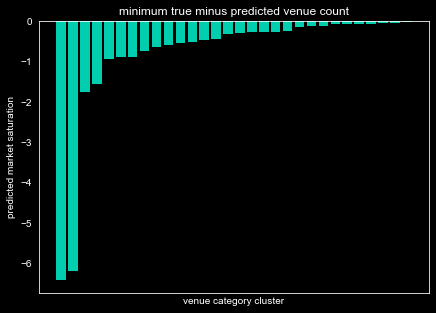

In [88]:
fig = plt.figure(figsize=(7,5))

plt.bar(table_differences_cluster.columns, table_differences_cluster.min().sort_values(),
        color='#01CEAF', edgecolor='None')
plt.xticks(ticks=[])
plt.title(label='minimum true minus predicted venue count')
plt.xlabel('venue category cluster')
plt.ylabel('predicted market saturation')

fig.savefig('figures/prediction_catcluster.png', transparent=True, dpi=300)

Check which venues are in the cluster that has our best hit, i.e. the highest predicted lack in any neighborhood.

In [89]:
print(table_differences_cluster.min().sort_values()[0:5],
     '\n\nThe highest demand over all cluster categories is found in cluster {}.'.format(
     int(table_differences_cluster.min().sort_values().index[0][8:])))

Cluster 14   -6.408285
Cluster 0    -6.189329
Cluster 27   -1.764793
Cluster 7    -1.551692
Cluster 15   -0.944352
dtype: float64 

The highest demand over all cluster categories is found in cluster 14.


Let us see, which categories are part of this cluster and let us check the avera R2-score of our linear regression models over these.

In [90]:
#Let us see which venue categorie belong to the cluster that displays the highest overall venue lack.
venue_cluster = list(table_cat_t_clusters[table_cat_t_clusters['K-Means (Random)']==
    int(table_differences_cluster.min().sort_values().index[0][8:])
    ].index)

print('This cluster contains the following categories:\n',
    venue_cluster)

#We also want to make sure that our R2-scores indicate correlation of our data with the number of venues in this category.
r2_cluster = []
for i in venue_cluster:
    #Subtract 5 (postal code, neighborhood, borough, longitude, latitude) as no R2-scores for these are in the list.
    r2_cluster.append(r2_scores[table_cat.columns.get_loc(i)-5])

print('The mean R2-score in this cluster is: ', round(sum(r2_cluster)/len(r2_cluster),2))


This cluster contains the following categories:
 ['Auto Workshop', 'Lingerie Store', 'Lounge', 'Portuguese Restaurant', 'Medical Center', 'Performing Arts Venue', 'Drugstore', 'Electronics Store', 'Golf Course', 'Bridal Shop', 'Frozen Yogurt Shop', 'Luggage Store', 'Sporting Goods Shop', 'Swim School', 'Baseball Stadium', 'Office', 'Antique Shop', 'Accessories Store', 'Video Game Store', 'Spa', 'Cosmetics Shop', 'Ice Cream Shop', "Women's Store", 'Skate Park', 'College Stadium', 'Sushi Restaurant', 'Garden Center', 'Hookah Bar', 'Scenic Lookout', 'Nightclub', 'Business Service', 'Coworking Space', 'Farm', 'Theater', 'Recording Studio', 'Music Venue', 'Ramen Restaurant', 'Cafeteria', 'Indonesian Restaurant', 'Noodle House', 'Train Station', 'Convention Center', 'Burrito Place', 'Poutine Place', 'Event Space', 'Greek Restaurant', 'College Auditorium', 'Roof Deck', 'Candy Store', 'Lake', 'Historic Site', 'College Rec Center', 'Bubble Tea Shop', 'Gas Station', 'Juice Bar', 'Bus Station', '

Good. Many of these are easily understandable, like tea shops and bakeries which serve coffee as well. Some are rather surprising, e.g. art places and museums, which seem to cater similar customer demands.

The highest demand within this category is found for:

In [91]:
table_differences[table_cat_t_clusters[table_cat_t_clusters['K-Means (Random)']==coffee_shop_cluster].index].min().sort_values().index[0:10]

Index(['Coffee Shop', 'Café', 'Italian Restaurant', 'Restaurant',
       'Japanese Restaurant', 'Gym', 'Pub', 'Department Store', 'Salad Place',
       'Burger Joint'],
      dtype='object')

Indeed, our first intuition was correct. Toronto needs more coffee. Let us look at the structure of the coffee shop demand over all neighborhoods.

Let us see how coffee shop market saturation is distributed over the Toronto neighborhoods.

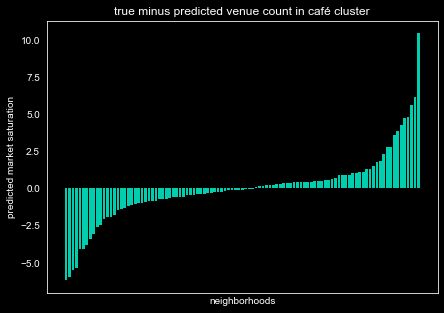

In [92]:
fig = plt.figure(figsize=(7,5))
plt.bar(table_differences_cluster.index, table_differences_cluster['Cluster '+str(coffee_shop_cluster)].sort_values(),
       color='#01CEAF', edgecolor="None")
plt.xticks(ticks=[])
plt.title(label='true minus predicted venue count in café cluster')
plt.xlabel('neighborhoods')
plt.ylabel('predicted market saturation')

fig.savefig('figures/prediction_neighborhoods.png', transparent=True, dpi=300)

Our prediction was able to capture a market saturation over the whole city that averages to a healthy value. However, as we have seen before, the distribution is lacklustre and there are neighborhoods that massively lack coffee supply.

Certain neighborhoods could need more than 3 (even 5 in the highest case) new venues from the café cluster.

Now we will go into more detail again and compare the categories within this cluster.

In [93]:
# We need to shorten the labels, as some category names are very long

top25 = table_differences[table_cat_t_clusters[table_cat_t_clusters['K-Means (Random)']==coffee_shop_cluster].index].min().sort_values().index[0:25]
top25_shortened=[]
for venue in top25:
    if len(venue)>10:
        top25_shortened.append(venue[:10-len(venue)]+'...')
    else:
        top25_shortened.append(venue)

    

We now visualize the 25 highest demands within this cluster.

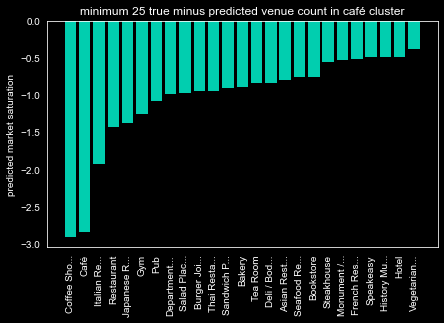

In [94]:
fig = plt.figure(figsize=(7,5))


plt.bar(top25_shortened,
        table_differences[table_cat_t_clusters[table_cat_t_clusters['K-Means (Random)']==coffee_shop_cluster].index].min().sort_values()[0:25],
       color='#01CEAF', edgecolor="None")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.25)
plt.title(label='minimum 25 true minus predicted venue count in café cluster')
plt.ylabel('predicted market saturation')
#plt.xlabel('venue category')
fig.savefig('figures/prediction_catmaxdemand.png', transparent=True, dpi=300)


Let us make sure that the demand for coffee is not always counterbalanced with coffee shops. We have already ensured that the cluster that caters this need is is strong need in certain neighborhoods.

In [95]:
#Make a list of combined coffee shop and café market saturations.
coffee_list = (table_differences['Coffee Shop'] + table_differences['Café'])
#Store the id of the minimum value of this list.
coffee_list_minidx = coffee_list[coffee_list==coffee_list.min()].index
#Show the neighborhood index and prediction of market saturation in this neighborhood.
coffee_list[coffee_list==coffee_list.min()]



99   -4.469289
dtype: float64

In [96]:
#Have a look at the category demand predictions of this neighborhood.
table_differences[
    table_differences[
        table_cat_t_clusters[table_cat_t_clusters[
            'K-Means (Random)'
        ]==coffee_shop_cluster
    ].index]
    .min().sort_values().index].iloc[
        coffee_list_minidx,:
    ]

Coffee Shop      Café  Italian Restaurant  Restaurant  \
99    -1.623507 -2.845782           -1.643973    0.189037   

    Japanese Restaurant       Gym       Pub  Department Store  Salad Place  \
99             2.268402 -0.714241  1.333698         -0.688021    -0.224792   

    Burger Joint  ...  Filipino Restaurant  Comic Shop  Wine Bar  \
99      1.396408  ...            -0.066678    0.006336 -0.000858   

    Health Food Store  Concert Hall  Gourmet Shop  Modern European Restaurant  \
99          -0.027942      0.000977      -0.00347                   -0.004821   

    Light Rail Station  Colombian Restaurant  Brazilian Restaurant  
99           -0.013348             -0.005696             -0.005696  

[1 rows x 69 columns]

Just judging by the market saturation of cafés and coffee shops, the smartest location to open a coffee shop would be in neighborhood 99. However, the market is quite saturated there by tea rooms, restaurants and other similar locations.

In [97]:
#Show the neighborhood's total market saturation for our coffee cluster.
table_differences_cluster['Cluster '+str(coffee_shop_cluster)][coffee_list_minidx]

99   -5.979093
Name: Cluster 0, dtype: float64

Within the café cluster, however, still a high venue lack of 6 venues is found. Let us also isolate the neighborhood with the highest cluster-based demand.

In [98]:
#Store the index of the neighborhood with the highest demand for venues from the most demanded cluster.
cluster_nh_minidx = table_differences_cluster[str('Cluster ' + table_differences_cluster.min().sort_values().index[0][8:])].sort_values().index[0]
cluster_nh_minidx

48

In [99]:
print( 'The highest demand for any cluster was found for our coffee shop cluster with a lack of {} venues.'.format(
    round(table_differences_cluster['Cluster '+str(coffee_shop_cluster)].min(),2)),
    '\nCafés and coffee shops combined yield a lack of {} venues in the neighborhood with the highest lack {} ({}).'.format(
    round(table_differences['Coffee Shop'][cluster_nh_minidx] + table_differences['Café'][cluster_nh_minidx],2),
    cluster_nh_minidx,
    table_cat.loc[cluster_nh_minidx, 'Neighborhood'])
    )

The highest demand for any cluster was found for our coffee shop cluster with a lack of -6.19 venues. 
Cafés and coffee shops combined yield a lack of 2.15 venues in the neighborhood with the highest lack 48 (Commerce Court, Victoria Hotel).


Very good. The cluster of venue categories capturing coffee shops is also well undersaturated in Church and Wellesley. Over 4 shops of the group of coffee shops and cafés would be needed to saturate the market. Let us visualize this demand.

<h3>3.12 Choropleth maps</h3>

Let us see if we can visualize our results nicely with the geojson that Toronto delivers due to their open data actions. The geojson is downloaded from the Toronto Open Data Portal.

Firstly, we generate a choropleth to look at the raw input geojson.

In [100]:
neighborhoods = 'Neighbourhoods.geojson'

#toronto_layer = folium.Chloropleth(toronto_neighborhood_gdp, name='Toronto Neighborhoods', show=True, fill_color='red', line_color='white')

map_coffee = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='stamentoner')

folium.GeoJson(
    neighborhoods,
    name='geojson'
).add_to(map_coffee)

map_coffee

<img src="figures/choropleth_raw.png"/>

This data set comes with 140 neighborhoods. Our postal code data set only distinguishes 103. We will have to assign our postal codes to this neighborhood set.

In [101]:
import json
with open('Neighbourhoods.geojson') as f:
    data = json.load(f)

We collect all geolocations of the Toronto neighborhoods.

In [102]:

#geo_df = pd.DataFrame(columns=['LATITUDE','LONGITUDE'])

list_lat = []
list_lng = []

for index in range(len(data['features'])):

    list_lat.append(data["features"][index]['properties']['LATITUDE'])
    list_lng.append(data["features"][index]['properties']['LONGITUDE'])

geo_df = pd.DataFrame(list(zip(list_lat, list_lng)), columns=['Latitude','Longitude'])
    
geo_df

Latitude  Longitude
0    43.676919 -79.425515
1    43.704689 -79.403590
2    43.687859 -79.397871
3    43.765736 -79.488883
4    43.714672 -79.457108
..         ...        ...
135  43.725556 -79.260382
136  43.653554 -79.397240
137  43.698993 -79.547863
138  43.653520 -79.510577
139  43.795716 -79.314084

[140 rows x 2 columns]

For assigning the neighborhoods to the postal code areas, we calculate the Haversine distances between the centroids.

In [103]:
distance_df = pd.DataFrame(columns =range(len(table_cat)))

for i in range(len(table_cat)):    
    loc1 = [table_cat['Latitude'][i],table_cat['Longitude'][i]]
    distance_list=[]
    
    
    for j in range(len(geo_df)): 
        loc2 = geo_df['Latitude'][j],geo_df['Longitude'][j]

        loc1_in_radians = [radians(_) for _ in loc1]
        loc2_in_radians = [radians(_) for _ in loc2]
        result = int(haversine_distances([loc1_in_radians, loc2_in_radians])[0][1]*6371000)
        distance_list.append(result)
        distance_df.loc[j,i] = distance_list[j]

#geo_df2 = geo_df2.reindex(columns = geo_df2.columns.tolist() + ['Closest_Neighborhood'])

        
#for i in range(len(table_cat)):
#    if len(geo_df2[geo_df2['Closest_Neighborhood']==i])>1:
#        for j in range(len(geo_df2[geo_df2['Closest_Neighborhood']==i])-1):
#            geo_df2.at[geo_df2[geo_df2['Closest_Neighborhood']==i]['Neighborhood_Index_'+str(i)].idxmax(), 'Closest_Neighborhood'] = np.nan
    
        



We need to isolate the postal code that is the closest to the neighborhoods.

In [104]:
distance_list = []
for i in distance_df.columns:
    distance_list += distance_df[i].values.tolist()
    
distance_list.sort()

#for i in distance_list:
#    distance_df[distance_df==93]

In [105]:
closest_neighborhood = []
for i in range(len(distance_df)):
    closest_neighborhood.append(np.nan)

To avoid double assignment, we need to run a loop that only assigns the closest hit.

In [106]:
k=int()

iteration = 0
while iteration<500:
    for i in distance_list:
        for j in range(len(table_cat)):
            #Add below line to the if statement, if unique indexing is looked for.
            #j not in closest_neighborhood and
            #As the neighborhoods are, however, smaller increments of the postal codes, we shall allow
            #double affiliation of the values.
            if j not in closest_neighborhood and distance_df[distance_df[j]==i].index.size>0:
                if np.isnan(closest_neighborhood[distance_df[distance_df[j]==i].index[0]]):
                    
                #k = distance_df[distance_df[j]==i].index
                    closest_neighborhood[distance_df[distance_df[j]==i].index[0]]=j
        iteration+=1

Let us store the neighborhoods that we assigned to postal codes in a new geojson.

In [107]:
data2 = data['features']

#for i in range(len(closest_neighborhood)):
#    if not np.isnan(closest_neighborhood[i]):
#        data2.remove(data[i])

In [108]:
data2 = [ elem for elem in data2 if not np.isnan(closest_neighborhood[data2.index(elem)])]

In [109]:
with open('Neighborhood2.geojson', 'w') as outfile:
    json.dump(data2, outfile)

Now let us visualize this.

In [110]:


neighborhood='Neighborhood2.geojson'

#toronto_layer = folium.Chloropleth(toronto_neighborhood_gdp, name='Toronto Neighborhoods', show=True, fill_color='red', line_color='white')

map_coffee = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='stamentoner')

folium.GeoJson(
    neighborhood,
    name='geojson'
).add_to(map_coffee)

map_coffee

<img src="figures/choropleth_firstlook.png"/>

Just assignig the 103 postal codes to the closest neighborhoods gives a quite uncomplete picture. Let us instead also assign further away neighborhoods to postal codes. We can see that the Toronto neighborhood data is covering the exact same region as the postal code data that we used for our analysis, but it is working in smaller increments. For nice representations, we will assume that the second closest neighborhood polygons belong to the same postal code.

In [111]:
closest_neighborhood = []
for i in range(len(distance_df)):
    closest_neighborhood.append([np.nan, np.nan])



We need to run a similar loo again, now allowing double assignment of neighborhoods.

In [112]:
k=int()
temp=[]
iteration = 0
while iteration<1000:
    for i in distance_list:
        for j in range(len(table_cat)):
            #Add below line to the if statement, if unique indexing is looked for.
            #j not in closest_neighborhood and
            #As the neighborhoods are, however, smaller increments of the postal codes, we shall allow
            #double affiliation of the values.
            if distance_df[distance_df[j]==i].index.size>0:
                #if np.isnan(closest_neighborhood[distance_df[distance_df[j]==i].index[0]][0]):
                k = distance_df[distance_df[j]==i].index[0]
                if np.isnan(closest_neighborhood[k][1]):
                    closest_neighborhood[k] = [data['features'][k]['properties']['AREA_ID'],j]
                    temp.append(j)
                if j not in temp:
                    if temp.count(closest_neighborhood[k][1])>1:
                #k = distance_df[distance_df[j]==i].index
                        closest_neighborhood[k] = [data['features'][k]['properties']['AREA_ID'],j]
                        temp.append(j)
            iteration+=1

Again, we identify the closest neighborhoods and check how succesful we were.

In [113]:
closest_df = pd.DataFrame(closest_neighborhood, columns = ['AREA_ID', 'closest_NH'])
closest_df = closest_df.reindex(columns = closest_df.columns.tolist() + ['value'])

for i in closest_df['closest_NH']:
    closest_df.loc[closest_df['closest_NH']==i, 'value'] = table_differences_cluster.loc[i, 'Cluster '+str(coffee_shop_cluster)]
    
#closest_df.drop(labels=[28],inplace=True)

len(closest_df['closest_NH'].unique())
#closest_df[closest_df['closest_NH']==99]

100

This way, we have been able to assign most of our postal codes to neighborhoods.

We now need to extract the keys of our geojson and save them in a dataframe with our values for the lack of coffee in the corresponding regions to generate a coffee heatmap.

In [114]:
#data2.rename_axis('INDEX')

cmap = folium.Map(location=[latitude+0.075, longitude+0.04], 
                    zoom_start=11)

minimum=int(table_differences_cluster['Cluster '+str(coffee_shop_cluster)].min())-1
maximum=int(table_differences_cluster['Cluster '+str(coffee_shop_cluster)].max())+1

cmap.choropleth(geo_data=neighborhoods, data=closest_df,
             columns=['AREA_ID', 'value'],
             key_on='feature.properties.AREA_ID',
             threshold_scale=[minimum, minimum/2, 0, maximum/2, maximum],
             fill_color='YlOrRd',
             highlight=True)


#Uncomment for generating a png file

#file = 'map.html'
#file_directory = '/C:/Users/Admin/Documents/Resources/Data%20Science%20Professional%20Certificate/data_science_pro_certification/'
#file_name = 'file://' + file_directory + file


#cmap.save(file)
#driver = webdriver.Chrome()  # Optional argument, if not specified will search path.
#driver.get(file_name)
#driver.set_window_size(1500, 1500)  # choose a resolution
# You may need to add time.sleep(seconds) here
#time.sleep(15)
#driver.save_screenshot('figures/screenshot.png')

cmap

C:\Users\Admin\Anaconda3\envs\jupyter-lab1\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


While this is a very nice representation, the picture it gives is not precise due to double association of postal codes over different neighborhoods that is not double checked with the actual neighborhood list used by Toronto. Our coordinate distance check would also sometimes chose neighborhoods that do not properly depict the postal codes, e.g. neighborhood 99 Church and Wellesley with the lowest market saturation in the coffee cluster is assigned wrongly.

<img src="figures/choropleth.png"/>

It should be the neighborhood west of the one marked with the lowest market saturation right now.

<img src="figures/church_and_wellesley.png"/>



<h3>3.12 Coffee-Demand Visualization</h3>

A better representation can be reached with circular markers. They show the exact origin of our requests to Foursquare and by size and color show the lack in market saturation within the cluster containing coffee shops. The button can also be used to switch to just showing coffee shop and café demand.

In [115]:
cmap = sns.dark_palette(color="#01CEAF", as_cmap=True)

def Draw_Map(Category, Show_Coffee, Zoom_City_Centre, Black_and_White, Screenshot, Report):
    
    if Category=='Whole cluster':
        coffee_lacks = table_differences_cluster['Cluster '+str(coffee_shop_cluster)]
    else:
        coffee_lacks = table_differences['Café'] + table_differences['Coffee Shop']
    
    #Take the negatives to show a lack rather than a market saturation.
    coffee_lacks = -coffee_lacks
    #Drop negative lacks so we can show the lack of our 
    coffee_lacks[coffee_lacks<0]=0
    


    if Zoom_City_Centre==True:
        initial_zoom_int = 12
        a=0. #latitude fine-tuning
        b=0. #longitude fine-tuning
    else:
        initial_zoom_int = 10
        a=0. #latitude fine-tuning
        b=0. #longitude fine-tuning
        
    map_clusters = folium.Map(location=[latitude+a, longitude+b], zoom_start=initial_zoom_int)
    
    if Black_and_White==True:
        folium.TileLayer('cartodbdark_matter').add_to(map_clusters)

    #kclusters=table_cat_clusters[method].max()+1
    # set color scheme for the clusters
    x = np.arange(15)
    ys = [i + x + (i*x)**2  for i in range(15)]
    colors_array = cmap(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, coffee_lack, venue_count in zip(table_cat['Latitude'], table_cat['Longitude'], table_cat['Neighborhood'], coffee_lacks, table_cat['Number of venues']):
        label = folium.Popup(str(poi) + '\nCoffee lack: ' + str(round(coffee_lack, 1)), parse_html=True)
        # create map
        if Zoom_City_Centre==True:
            marker_radius = (coffee_lack*3+1)*4
        else:
            marker_radius = (coffee_lack*3+1)
        marker_color=int(coffee_lack-max(coffee_lacks)+14)
        #Create circle markers with different colors for each cluster.
        folium.CircleMarker(
            [lat, lon],
            radius=marker_radius,
            popup=label,
            color=rainbow[marker_color],
            fill=True,
            fill_color=rainbow[marker_color],
            fill_opacity=0.6,
            weight=0).add_to(map_clusters)
        
        #Add text markers denouncing the predicted amount of market saturation lack.
        if Show_Coffee==True:
            folium.map.Marker(
                [lat, lon],
                icon=DivIcon(
                size=(150,36),
                anchor=(157,8),
                html=str(round(coffee_lack,1)),
                style="""
                    font-size:12px;
                    background-color: transparent;
                    border-color: transparent;
                    text-align: right;
                    """
            )
            ).add_to(map_clusters)

    if Screenshot == True:
        
        #Selenium does not work with relative paths. You will need to adapt the directory in order to take an automatic
        #screenshot.
        category=""
        if Category=="Whole cluster":
            category="_wholecluster"
        else:
            category="_coffeeshops"
                
        text_zoom=""
        if Zoom_City_Centre== True:
            text_zoom="_zoom"
            
        text_bnw=""
        if Black_and_White==True:
            text_bnw="_bnw"
        
        text_labels=""
        if Show_Coffee==True:
            text_labels="_labels"
        
        map_screenshot(map_clusters, mapfilename="map{}{}{}{}".format(category, text_zoom, text_bnw, text_labels))
    
    return map_clusters

interact(Draw_Map,
    Category=['Whole cluster', 'Coffee shops and cafés'],
    Show_Coffee=False, 
    Zoom_City_Centre=False,
    Black_and_White=False,
    Screenshot=False,
    Report=False
    )



interactive(children=(Dropdown(description='Category', options=('Whole cluster', 'Coffee shops and cafés'), va…

<function __main__.Draw_Map(Category, Show_Coffee, Zoom_City_Centre, Black_and_White, Screenshot, Report)>

This interface can be used to define the details of the shown map.

<img src="figures/areamarker_interactive.png"/>

The first heatmap of demand within our cluster of venue categories shows that a few neighborhoods show significant lack of venues to form a healthy neighborhood structure.

<img src="figures/map_wholecluster_bnw.png"/>

A zoom into downtown Toronto can clarify the relationships.

<img src="figures/map_wholecluster_zoom_bnw.png"/>

When we restrict the demand to only coffee shops and cafés (the highest demanded locations within this cluster from our earlier analysis) neighborhood 99 Church and Wellesley is found as clear victor in our search for a good location to launch a cofee-related business.

<img src="figures/map_coffeeshops_bnw.png"/>

Zooming in supports this notion further. There is only one neighborhood in the vicinity that does not display significant lack of coffee shops east of Church and Wellesley (St. James town, Cabbage town). It does, however, still display a lack of 0.3 and likely is saturated with coffee shops only outside of the reach of Church and Wellesley.

<img src="figures/map_coffeeshops_zoom_bnw.png"/>



Let us finally visualize the demand for
<li>the categories coffee shop/café</li>
<li>the whole coffee cluster</li>
<li>the product of both</li>

In [116]:
cmap = sns.dark_palette(color="#01CEAF", as_cmap=True)

def Draw_Map(Show_Coffee, Zoom_City_Centre, Black_and_White, Screenshot, Report):
    # Demand in the whole cluster.
    cluster_lacks = table_differences_cluster['Cluster '+str(coffee_shop_cluster)]
    # Coffee and café lack
    coffee_lacks = table_differences['Café'] + table_differences['Coffee Shop']
    # The product of both gives a good measure of demand that is not met due to other venues in the cluster
    #coffee_lacks_product = table_differences_cluster['Cluster '+str(coffee_shop_cluster)].multiply(table_differences['Café'] + table_differences['Coffee Shop'])
    
    #Take the negatives to show a lack rather than a market saturation.
    cluster_lacks = -cluster_lacks
    #Drop negative lacks so we can show the lack of our 
    cluster_lacks[cluster_lacks<0]=0
    
        #Take the negatives to show a lack rather than a market saturation.
    coffee_lacks = -coffee_lacks
    #Drop negative lacks so we can show the lack of our 
    coffee_lacks[coffee_lacks<0]=0
    
        #Take the negatives to show a lack rather than a market saturation.
    #coffee_lacks_product = -coffee_lacks_product
    #Drop negative lacks so we can show the lack of our 
    #coffee_lacks_product[coffee_lacks_product<0]=0
    
    coffee_lacks_product = cluster_lacks.multiply(coffee_lacks)
    
    if Zoom_City_Centre==True:
        initial_zoom_int = 12
        a=0. #latitude fine-tuning
        b=0. #longitude fine-tuning
    else:
        initial_zoom_int = 10
        a=0. #latitude fine-tuning
        b=0. #longitude fine-tuning
        
    map_clusters = folium.Map(location=[latitude+a, longitude+b], zoom_start=initial_zoom_int)
    
    if Black_and_White==True:
        folium.TileLayer('cartodbdark_matter').add_to(map_clusters)

    #kclusters=table_cat_clusters[method].max()+1
    # set color scheme for the clusters
    x = np.arange(15)
    ys = [i + x + (i*x)**2  for i in range(15)]
    colors_array = cmap(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster_lack, coffee_lack, coffee_lack_product, venue_count in zip(table_cat['Latitude'], table_cat['Longitude'], table_cat['Neighborhood'], cluster_lacks, coffee_lacks, coffee_lacks_product, table_cat['Number of venues']):
        label = folium.Popup(str(poi) + '\nCluster lack: ' + str(round(cluster_lack, 1)), parse_html=True)
        label2 = folium.Popup(str(poi) + '\nCoffee lack: ' + str(round(coffee_lack, 1)), parse_html=True)
        label3 = folium.Popup(str(poi) + '\nLack product: ' + str(round(coffee_lack_product, 1)), parse_html=True)
        
        # create map
        if Zoom_City_Centre==True:
            marker_radius = (cluster_lack*3+1)*1
            marker_radius2 = (coffee_lack*3+1)*1
            marker_radius3 = (coffee_lack_product*3+1)*1
        else:
            marker_radius = (cluster_lack*3+1)*0.6
            marker_radius2 = (coffee_lack*3+1)*0.6
            marker_radius3 = (coffee_lack_product*3+1)*0.6
        
        marker_color=int(cluster_lack-max(cluster_lacks)+14)
        marker_color2=int(coffee_lack-max(coffee_lacks)+14)
        marker_color3=int(coffee_lack_product-max(coffee_lacks_product)+14)
        
        #Create circle markers with different colors for each cluster.
        folium.CircleMarker(
            [lat, lon],
            radius=marker_radius3,
            popup=label3,
            color='red',
            fill=True,
            #fill_color='#01CEAF',#rainbow[marker_color3],
            line_color='yellow',
            fill_opacity=0.2,
            weight=1.5).add_to(map_clusters)
        folium.CircleMarker(
            [lat, lon],
            radius=marker_radius,
            popup=label,
            color='yellow',#rainbow[marker_color],
            fill=True,
            #fill_color='red',#rainbow[marker_color],
            fill_opacity=0.2,
            weight=1.5).add_to(map_clusters)     
        folium.CircleMarker(
            [lat, lon],
            radius=marker_radius2,
            popup=label2,
            color='#01CEAF',
            fill=True,
            #fill_color=rainbow[marker_color2],
            #line_color='r',
            fill_opacity=0.6,
            weight=0).add_to(map_clusters)
           
        #Add text markers denouncing the predicted amount of market saturation lack.
        if Show_Coffee==True:
            folium.map.Marker(
                [lat, lon],
                icon=DivIcon(
                size=(150,36),
                anchor=(157,8),
                html=str(round(coffee_lack,1)),
                style="""
                    font-size:12px;
                    background-color: transparent;
                    border-color: transparent;
                    text-align: right;
                    """
            )
            ).add_to(map_clusters)

    if Screenshot == True:
        
        #Selenium does not work with relative paths. You will need to adapt the directory in order to take an automatic
        #screenshot.
                      
        text_zoom=""
        if Zoom_City_Centre== True:
            text_zoom="_zoom2"
            
        text_bnw=""
        if Black_and_White==True:
            text_bnw="_bnw"
        
        text_labels=""
        if Show_Coffee==True:
            text_labels="_labels"
        
        map_screenshot(map_clusters, mapfilename="map_conclusions_combinedproduct_{}{}{}".format(text_zoom, text_bnw, text_labels))
    
    return map_clusters

interact(Draw_Map,
    Show_Coffee=False, 
    Zoom_City_Centre=False,
    Black_and_White=False,
    Screenshot=False,
    Report=False
    )



interactive(children=(Checkbox(value=False, description='Show_Coffee'), Checkbox(value=False, description='Zoo…

<function __main__.Draw_Map(Show_Coffee, Zoom_City_Centre, Black_and_White, Screenshot, Report)>

Fantastic. The green markers show the coffee/café lack. Yellow indicates the venue demand in the whole category cluster. Red indicates the product of both, which is a good measure for true demand. This amplifies the demand for coffee shops/cafés in areas where a need for venues in the whole cluster exists. This way, we can make sure that the need for coffee is not catered by other venues serving the same or similar beverages.

<img src="figures/map_conclusions_combinedproduct__bnw.png"/>

<img src="figures/map_conclusions_combinedproduct__zoom2_bnw.png"/>

<h3>4. Discussion</h3>

This analysis is based on Foursquare data of neighborhoods within 500 m of the centres of Toronto's 103 postal codes. From this, we deduced the market saturation of venues of different categories. Further data, such as population, income, etc. could further increase the precision of our analysis, however, with a stable nature of the venue structure in Toronto we can assume that the existence of venues is a good predictor of their health und functionality which, in turn, is an indirect measure of the existence and wealth of customers.

Our results clearly demonstrate that additional venues selling coffee (coffee shops and cafés) are in high demand in Toronto. Based on the amount of existing venues, 271 linear regression models were trained to predict the amount of venues in certain categories within different postal codes in Toronto. This assumes that temporary fluctuations can be neglected which leads to the dataset describing healthy venue category structures within areas of Toronto.

The amount of independent variables was reduced by K-Means clustering (k-means++ initialization) of the venue categories in order to identify groups within our categories so that we can capture different categories that also cater the same needs as others. We chose to reduce the dimensionality to one third of the original number of categories (k=91). Grouping these data and comparing our predicted venue counts with the true venue counts, a group of categories was identified that shows significant lacks in market saturation.

This group contains the following venue categories: 'Japanese Restaurant', 'New American Restaurant', 'Cocktail Bar', 'Gym', 'General Entertainment', 'Fountain', 'Vegetarian / Vegan Restaurant', 'Basketball Stadium', 'American Restaurant', 'Gastropub', 'Restaurant', 'Breakfast Spot', 'Taco Place', 'IT Services', 'Department Store', 'Irish Pub', 'Beer Bar', 'Ice Cream Shop', 'Museum', 'French Restaurant', 'Hotel', 'Wine Bar', 'Jazz Club', 'Poke Place', 'Food Court', 'Art Gallery', 'Bistro', 'Plaza', 'Bakery', 'Thai Restaurant', 'Tea Room', 'Coffee Shop', 'Tailor Shop', 'Roof Deck', 'Lounge', 'Café', 'Steakhouse', 'Creperie', 'Seafood Restaurant'.

This is a very interesting intermediate results. Further data is needed to establish if this categorization can be used outside of our training set. Many of the venues can be intuitively understood to cater the same needs as coffee shops, as they likely serve coffee (e.g. roof deck, lounge, creperie, bakery) but there are also more surprising hits (e.g. IT services, museum, general entertainment). Such venues in the neighborhood shall be taken into account when trying to precidt the success of venues of certain categories.

A more detailed analysis of this group showed that the highest demands are found for coffee shops and cafés. Intriguingly, a very high demand for both comes together in Church and Wellesley. Comparing this found demand to the market saturation within the whole venue category cluster validates this finding. The other locations that our algorithm found comparable to coffee shops are also not saturated, meaning that high success chances for coffee shops or cafés can be predicted for launching a new venue in this neighborhood.

This neighborhood seems privileged. In our initial explorative clustering of the neighborhoods by their venue counts, venues in categories, and their mean distance between venues, by four different approaches (K-Means with k-means++ initialization, with random initialization, with random initialization and Principal Component Analysis, and Agglomerative Clustering) this neighborhood was placed in a dedicated cluster (k=5), once again supporting the extraordinary nature of this neighborhood.

Judging by the venue structures in other neighborhoods of Toronto, Church and Wellesley seems to have an unhealthy structure. This poses large chances for benefitting from the neighborhood's structure when introducing venues that cater needs which are currently not met. Our analysis predicts a lack of 6 venues of the cluster (differs based on random state of clustering), 4.5 of which should be coffee shops or cafés.


<h3>5. Conclusion</h3>

Toronto shows a diverse culture of stores, restaurants, etc. With an ever-changing city, the market saturation of different categories of venues fluctuates. We found that a timeless classic is in extreme demand right now and found it strongly recommendable to launch coffee shops and cafés in the Church and Wellesley neighborhood in Toronto. This neighborhood was shown to stand out among Toronto's neighborhoods and showed a strong lack of any type of similar venue so that little competition is to be expected. The venue structure within this neighborhood would even support four additional coffee shops.

<img src="figures/coffee.jpg"/>
Photography: Mike Kenneally via unsplash.com